In [1]:
#General dataframe
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
import scipy.stats as scistat
from datetime import datetime
import time
import os
import pickle

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#ScipyStats
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import TimeSeriesSplit

#Set seeds where possible
import random
random.seed(200)
np.random.seed(200)

#Import required SkLearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Help ignore the high verbosity in optuna
import warnings
warnings.filterwarnings("ignore")


#Import Optuna tuning hyperparameter
!pip install optuna
import optuna
from optuna.visualization import plot_optimization_history, plot_slice
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler

#Import statsmodels
import statsmodels.api as sm

Defaulting to user installation because normal site-packages is not writeable


#### Establish Test Parameters
y_val = target variable for the study

stock_x_cols = feature variables to include if you are adding cross-sectional stock features

start_date = starting date for data

re_train_dates = a list of dates for which to train the model

test_length_years = # of years to test the model

CV_length_years = # of years to cross-validate the model

In [2]:
#Insert parameters here 
target = ['1m_fwd_ret']
stock_x_cols = ['mvel1', 'beta', 'bm', 'operprof', 'agr', 'sic2'] 
upload_cols = ['DATE', 'permno', 'mvel1', 'beta', 'bm', 'operprof', 'agr', 'sic2', '1m_fwd_ret']
start = '1973-01-31'
re_train_dates = [pd.to_datetime('2003-12-31')]
test_length_years = 19
CV_length_years = 10

#Setup base folder path here
base_path = "C:/Users/andrew_lazzeri/Desktop/Project_Files/Data Upload/"


#### Upload the processed data from File #1

In [3]:
mylist = []
filename = base_path + "final_cross_section_df.csv"
df_test = pd.read_csv(filename, nrows = 1)
col_conv = {c: np.float32 for c in df_test.columns}
del df_test 

for chunk in  pd.read_csv(filename, sep=',', usecols=upload_cols, chunksize=5000, error_bad_lines = False, engine='python'):
    mylist.append(chunk)

security_df = pd.concat(mylist, axis= 0)
del mylist

def date_align(df, col):
    
    """
    Function to align all dates to the end of the month across various databases
    """
    exceptions = []
    date_list = sorted(list(set(df[col])))
    date_convert = {}
    for date in date_list:
        try:
            date_convert[date] = pd.offsets.MonthEnd().rollforward(date)
        except:
            exceptions.append(date)
            continue 
            
    df[col] = df[col].replace(date_convert)
    return df, exceptions

security_df['DATE'] = pd.to_datetime(security_df['DATE'])
security_df = security_df.set_index(['DATE', 'permno'])
security_df = security_df.astype(np.float32)
security_df['sic2'] = security_df['sic2'].astype('category')
security_df = security_df[security_df.index.get_level_values('DATE')>=start]

security_df.index = security_df.index.set_names(['date', 'permno'])
security_df = security_df.reset_index()
security_df = security_df.drop_duplicates(subset=['date', 'permno'])
security_df = security_df.set_index(['date', 'permno'])
security_df['sic2'] = security_df['sic2'].astype(float)


#Setup the sic2 aggregates
security_df['sic_agg'] = np.nan
security_df['sic_agg'] = np.where(security_df['sic2'] < 10, 'Ag, Forest & Fishing', security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 10) & ((security_df['sic2'] < 15)), 
                                 'Mining',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 15) & ((security_df['sic2'] < 18)), 
                                 'Construction',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 20) & ((security_df['sic2'] < 40)), 
                                 'Manufacturing',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 40) & ((security_df['sic2'] < 50)), 
                                 'Transportation, Comm, Etc.',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 50) & ((security_df['sic2'] < 52)), 
                                 'Wholesale Trade',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 52) & ((security_df['sic2'] < 60)), 
                                 'Retail Trade',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 60) & ((security_df['sic2'] < 68)), 
                                 'Finance, Insurance, Real Estate',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 70) & ((security_df['sic2'] < 90)), 
                                 'Services',security_df['sic_agg'])
security_df['sic_agg'] = np.where((security_df['sic2'] >= 91) & ((security_df['sic2'] < 97)), 
                                 'Public Admin',security_df['sic_agg'])
security_df['sic_agg'] = np.where(security_df['sic_agg'] == 'nan', 'Unknown', security_df['sic_agg'])
security_df['sic_agg'].value_counts(normalize=True)
security_df = security_df.drop(['sic2'], axis=1)

macro_path = base_path + "Macroeconomic_Training_Data.csv"
macro_df = pd.read_csv(macro_path)
macro_df['Dates'] = pd.to_datetime(macro_df['Dates']) 
macro_df, exceptions = date_align(macro_df, 'Dates')
macro_df = macro_df.set_index('Dates')
macro_df.index.name = 'date'
macro_df = macro_df[macro_df.index >= start]
macro_df = macro_df.dropna(axis='columns')


In [4]:
macro_path = base_path + "Macroeconomic_Training_Data.csv"
macro_df = pd.read_csv(macro_path)
macro_df['Dates'] = pd.to_datetime(macro_df['Dates']) 
macro_df, exceptions = date_align(macro_df, 'Dates')
macro_df = macro_df.set_index('Dates')
macro_df.index.name = 'date'
macro_df = macro_df[macro_df.index >= start]
macro_df = macro_df.dropna(axis='columns')


### Setting Up the Specific Regimes
The below functions setup the dates for the study's regimes.  Here there are two sets of dates we will employ, the first is simply any period in which the S&P 500 return is negative over the next month counts as a down market.  The second is based on NBER recession dates which are gathered form FRED.

In [5]:
def SP_regime(macro_df, base_path):
    regime_df = pd.DataFrame(macro_df['S&P 500'].shift(-1)) #To match the forward forecasts
    regime_df['DownMkt'] = np.where(regime_df['S&P 500'] < 0, 1, 0)
    return pd.DataFrame(regime_df['DownMkt'])

def NBER_regime(base_path):
    NBER_df = pd.read_csv(base_path + "USREC.csv")
    NBER_df['DATE'] = pd.to_datetime(NBER_df['DATE']) + DateOffset(days = -1)
    NBER_df.columns = ['date', 'Recession']
    NBER_df = NBER_df.set_index('date')
    NBER_df = NBER_df.resample('M').ffill()
    return NBER_df

def construct_regime_df(start, macro_df, base_path):
    NBER_regime_df = NBER_regime(base_path)
    SP_regime_df = SP_regime(macro_df, base_path)
    final_regime_df = NBER_regime_df.join(SP_regime_df)
    final_regime_df = final_regime_df[final_regime_df.index >= start]
    final_regime_df.to_csv(base_path + 'Regime_df.csv')
    return final_regime_df

final_regime_df = construct_regime_df(start, macro_df, base_path)
    

In [18]:
### The below function data is for cleaning and pre-processing the dataframe 
#Packages
from pandas.tseries.offsets import DateOffset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

#Convert various forms of issue rows into nans and drop with parameters to drop rows and columns based on specific thresholds
def drop_nasties(df, row_perc: float, col_perc: float, remove_duplicates = True):
    """
    Takes in a dataframe and: 
    -replaces infinities with nans for processing
    -drops rows with certain missing value percentages
    -drops columns with certain missing value percentages
    -keeps the first entry of a completely duplicated column
    """
    
    rows, cols = df.shape
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis = 0, thresh = int(row_perc*cols), inplace=True)
    df.dropna(axis = 1, thresh = int(col_perc*rows), inplace=True)
    df.drop_duplicates(keep='first', inplace=remove_duplicates)
    return df

#One hot encode categorical columns, drop the original categorical columns and rejoin the one hot encoded columns to OG dataframe
def one_hot_encode(df, cat_cols):
    """
    One hot encode the categorical variables.  
    Here that would be the SIC codes
    """
    
    dummy_df = pd.get_dummies(df[cat_cols])
    return_df  =  df.join(dummy_df, how = 'left')
    return_df.drop(cat_cols, axis = 1, inplace = True)
    return  return_df

#Split the dataframe axis along the date axis and divide the data into training, CV and test periods
#The period inputs here represent the number of years to include in each period and will be X years back from the current date
def time_split(df, train_end, CV_end):
    """
    Split the data into train and CV sets based on manually assigned dates
    """
    #current_date = current_date + DateOffset(months = 0)
    train_end = pd.offsets.MonthEnd().rollforward(train_end)
    CV_end = pd.offsets.MonthEnd().rollforward(CV_end)
    
    #Split dataframes into train, CV, test
    train_df = df[df.index.get_level_values('date') <= train_end]
    CV_df = df[(df.index.get_level_values('date') > train_end) & (df.index.get_level_values('date') <= CV_end)]  
    return train_df, CV_df

#Identify columns with missing target variables.  While I impute some values a missing target is dropable
def missing_y_vars(train_df, CV_df, target):
    """
    Drops x feature variabes when the y variable is missing (no fwd return)
    Note, this will vary based on the target variable 
    """
    train_df = train_df.dropna(subset=target)  
    CV_df = CV_df.dropna(subset=target) 
    return train_df, CV_df

#Seperates the dataframes into X and Y variables
def separate_y_variables(train_df, CV_df, y_cols):
    """
    Split out y variables in the train, CV and test set
    """
    #Gather y variables
    train_y = train_df[y_cols]
    CV_df_y = CV_df[y_cols]
    #Remove y variables
    train_x = train_df.drop(y_cols, axis = 1)
    CV_df_x = CV_df.drop(y_cols, axis = 1)
    return  train_y, train_x, CV_df_y, CV_df_x

#Splits out numerical dataframes for further manipulation
def numerical_dfs(train_df, CV_df, numerical_cols):
    """
    Seperate numerical columns for train, CV and test data
    """
    train_scaled = train_df[numerical_cols]
    CV_scaled = CV_df[numerical_cols]
    return train_scaled, CV_scaled

#Winsorize each dataframe cross sectionally based on percentile values for a specific date index
def winsorize(train_y, train_x, CV_y, CV_x, lower_lim, upper_lim):
    from scipy.stats import mstats
    
    """
    Winsorize each data set based on the month's observations
    lower_lim / upper_lim serve as the percentile bounds for the wisorization
    """

    def winsorize_series(x):
        return mstats.winsorize(x, limits=[lower_lim,upper_lim])

    #Apply to all the dataframes
    train_y = train_y.groupby(train_y.index.get_level_values('date')).transform(winsorize_series)
    train_x = train_x.groupby(train_x.index.get_level_values('date')).transform(winsorize_series)
    CV_y = CV_y.groupby(CV_y.index.get_level_values('date')).transform(winsorize_series)
    CV_x = CV_x.groupby(CV_x.index.get_level_values('date')).transform(winsorize_series)
    return train_y, train_x, CV_y, CV_x

def normal_scaler(train_df, CV_df):
    
    """
    Takes in the train, CV and test df and applies a simple min max scaler
    The scaler is based on grouped values by date to avoid look ahead bias 
    In effect this performs a cross sectional min max scale at each date
    """

    def normal_transformer(x):
        return (x - x.mean())/(x.std())

    train_df = pd.DataFrame(train_df.groupby(train_df.index.get_level_values('date')).transform(normal_transformer),
                            columns = train_df.columns, index = train_df.index)
    CV_df = pd.DataFrame(CV_df.groupby(CV_df.index.get_level_values('date')).transform(normal_transformer),
                            columns = CV_df.columns, index = CV_df.index)
    return train_df, CV_df

#Impute using the median of min max scaled values
#Uses values from the training set for training and CV and uses the more current CV values for the test set
def imputer(train_df, CV_df):
    """
    Imputes the train, CV and test data. 
    The filler is initially calculated based on the train df and applied to the train and CV
    The test set is based on the CV data as this would be availble subsequently and is more contemporary
    """
    filler = train_df.median()
    train_df = train_df.fillna(filler)
    CV_df = CV_df.fillna(filler)
    return train_df, CV_df

#Simply rejoins the one hot encoded and numerical dataframes.  Added to make the main function more concise.
def recombine_dfs(train_x_num, CV_x_num, train_df, CV_df):
    """
    Rejoin the one hot encoded and numerical dataframes
    """
    #Extract the one hot encoded columns
    train_one_hot = train_df.select_dtypes(include = ["uint8"])
    CV_one_hot = CV_df.select_dtypes(include = ["uint8"])
        
    #Join the dataframes 
    train_x_num = train_x_num.join(train_one_hot, how = 'left')
    CV_x_num = CV_x_num.join(CV_one_hot, how = 'left')
    return train_x_num, CV_x_num

def df_preprocessing_cross_section(df, target, train_end, CV_end):
    """
    This function implements all of the functions in the desired sequences
    -Currently I am commenting out functions which may be helpful later but not currently in use
    """
    #time_split(df, train_end, CV_end)
    iter_df = df.copy()
    iter_df = drop_nasties(iter_df, 0, 0)
    cat_cols  =  iter_df.select_dtypes(include = ["category", "object"]).columns
    numerical_cols = iter_df.select_dtypes(include = ["number"]).columns
    numerical_cols = [col for col in list(numerical_cols) if col not in target] 
  
    #One hot encode categorical 
    iter_df = one_hot_encode(iter_df, cat_cols)

    #Divide the data into train, CV, test_dfs and remove potential target variables
    train_df, CV_df = time_split(iter_df, train_end, CV_end)
    train_df, CV_df = missing_y_vars(train_df, CV_df, target)
    train_y, train_x, CV_y, CV_x = separate_y_variables(train_df, CV_df, target)
    
    #Split out numerical columns, winsorize, min max scale, median impute
    train_x_num, CV_x_num = numerical_dfs(train_x, CV_x, numerical_cols)
    train_y, train_x_num, CV_y, CV_x_num = winsorize(train_y, train_x_num, CV_y, CV_x_num, .02, .02)
    train_x_num, CV_x_num = normal_scaler(train_x_num, CV_x_num)
    train_x_num, CV_x_num = imputer(train_x_num, CV_x_num)
    train_x, CV_x = recombine_dfs(train_x_num, CV_x_num, train_df, CV_df)
    
    #Add Prefixes to X dfs
    train_x = train_x.add_prefix('STOK_')
    CV_x = CV_x.add_prefix('STOK_')
    
    #Recombine targets and x variables
    train_df = train_x.join(train_y)
    CV_df = CV_x.join(CV_y)
    return train_df, CV_df

def save_cross_section(train_x, train_y, CV_x, CV_y, test_x, test_y, path, date):
    train_x.to_csv(path + 'train_x_' + str(date)[0:4] + '.csv')
    train_y.to_csv(path + 'train_y_' + str(date)[0:4] + '.csv')
    CV_x.to_csv(path + 'CV_x_' + str(date)[0:4] + '.csv')
    CV_y.to_csv(path + 'CV_y_' + str(date)[0:4] + '.csv')

def econ_key(base_path, macro_df):
    """
    Takes the values from the McCracken Key and replace the macro columns with the 
    McCracken full series name for interpretation.
    """
    key_df = pd.read_csv(base_path + "FREDMD_updated_appendix.csv", encoding='mac_roman')
    fred_list = key_df['fred'].to_list()
    desc_list = key_df['description'].to_list()
    econ_dict = {}
    for i in range(len(fred_list)):
        econ_dict[fred_list[i]] = desc_list[i]
    
    col_df = pd.DataFrame(list(macro_df.columns))
    col_df = col_df.replace(econ_dict)
    col_df.columns = ['SeriesName']
    new_cols = col_df['SeriesName'].to_list()
    macro_df.columns = new_cols 
    
    return macro_df

def macro_time_split(df, train_end, CV_end):
    """
    Split the data into train and CV sets based on manually assigned dates
    """
    #current_date = current_date + DateOffset(months = 0)
    train_end = pd.offsets.MonthEnd().rollforward(train_end)
    CV_end = pd.offsets.MonthEnd().rollforward(CV_end)
    #Split dataframes into train, CV, test
    train_df = df[df.index.get_level_values('date') <= train_end]
    CV_df = df[df.index.get_level_values('date') > train_end]  
    return train_df, CV_df

def macro_winsorization(train_df, CV_df, lower_lim, upper_lim):
    from scipy.stats import mstats
    """
    Winsorize each data set based on the month's observations
    lower_lim / upper_lim serve as the percentile bounds for the wisorization
    """
    def macro_winsorize_series(x):
        return mstats.winsorize(x, limits=[lower_lim,upper_lim])
    
    stacked_df = pd.concat([train_df, CV_df])
    PIT_winsorization_df = train_df.apply(macro_winsorize_series).copy()
    for i in range(train_df.shape[0], stacked_df.shape[0]+1, 1):
        iter_df = stacked_df.iloc[0:i, :]
        iter_df = iter_df.apply(macro_winsorize_series)
        PIT_winsorization_df = pd.concat([PIT_winsorization_df, iter_df.tail(1)])
    
    win_train = PIT_winsorization_df.iloc[0:train_df.shape[0], :]
    win_CV = PIT_winsorization_df.iloc[train_df.shape[0]:(train_df.shape[0] + CV_df.shape[0]+1), :]
    return win_train, win_CV

def macro_normal_scaler(train_df, CV_df):  
    """
    Takes in the train, CV and test df and applies a simple min max scaler
    The scaler is based on grouped values by date to avoid look ahead bias 
    In effect this performs a cross sectional min max scale at each date
    """     
    scaler_train = StandardScaler()
    train_df = pd.DataFrame(scaler_train.fit_transform(train_df), columns = train_df.columns,
                            index = train_df.index)
    CV_df = pd.DataFrame(scaler_train.transform(CV_df), columns = CV_df.columns,
                            index = CV_df.index)
    return train_df, CV_df

def macro_preprocessing(macro_df, train_end, CV_end, base_path):
    macro_df = econ_key(base_path, macro_df)
    macro_df = macro_df.add_prefix('ECON_')
    train_df, CV_df = macro_time_split(macro_df, train_end, CV_end)
    win_train, win_CV = macro_winsorization(train_df, CV_df, .02, .02)
    train_df, CV_df = macro_normal_scaler(win_train, win_CV)
    return train_df, CV_df

def merge_dataframes(security_df, target, train_end, CV_end, macro_df, base_path):
    train_x, CV_x = df_preprocessing_cross_section(security_df, target, train_end, CV_end)
    train_df, CV_df = macro_preprocessing(macro_df, train_end, CV_end, base_path)
    train_x = train_x.reset_index().set_index('date').drop(['permno'], axis=1)
    CV_x = CV_x.reset_index().set_index('date').drop(['permno'], axis=1)
    final_train_x = train_x.join(train_df)
    final_CV_x = CV_x.join(CV_df)
    return final_train_x, final_CV_x

def PCA_inst(df, explained_var):
    pca = PCA(n_components = explained_var)
    pca.fit(df)
    EVR = pca.explained_variance_ratio_
    SVs = pca.singular_values_ 
    PCA_Loadings = pd.DataFrame(pca.components_.T, index = df.columns, columns = ['PC_'+str(i) for i in range(len(EVR))])
    PCA_transforms = pd.DataFrame(pca.fit_transform(df), index = df.index, columns = ['PC_'+str(i) for i in range(len(EVR))])
    return PCA_Loadings, PCA_transforms, EVR

def merge_PCA_dataframes(security_df, target, train_end, CV_end, macro_df, base_path):
    train_x, CV_x = df_preprocessing_cross_section(security_df, target, train_end, CV_end)
    train_df, CV_df = macro_preprocessing(macro_df, train_end, CV_end, base_path)
    PCA_Loadings, PCA_df, EVR = PCA_inst(train_df, .95)
    PCA_Loadings.to_csv(base_path + 'PCA_Loadings.csv')
    train_x = train_x.reset_index().set_index('date').drop(['permno'], axis=1)
    final_train_x = train_x.join(PCA_df)
    return final_train_x, PCA_Loadings

def industry_df(X, y, col, target_col, base_cols):
    iter_train = X[X[col] == 1]
    iter_train = iter_train[base_cols]
    iter_train = iter_train.join(y)
    iter_train_y = iter_train[target_col]
    iter_train_x = iter_train.drop(target_col, axis=1)
    return iter_train_x, iter_train_y

def regime_dfs(final_regime_df, data_df, col):
    specific_regime = final_regime_df[col]
    data_df = data_df.join(specific_regime)
    regime_1_df = data_df[data_df[col] == 1].drop(col, axis=1)
    regime_2_df = data_df[data_df[col]!=1].drop(col, axis=1)
    return regime_1_df, regime_2_df

def split_df(train_df, CV_df, final_train, target):
    train_df = train_df.dropna()
    CV_df = CV_df.dropna()
    final_train = final_train.dropna()
    iter_train_y = train_df[target[0]]
    iter_CV_y = CV_df[target[0]]
    final_y = final_train[target[0]]
    iter_train_x = train_df.drop(target, axis=1)
    iter_CV_x = CV_df.drop(target, axis=1)
    final_x = final_train.drop(target, axis=1)
    return iter_train_y, iter_CV_y, final_y, iter_train_x, iter_CV_x, final_x

def optimization_instance(objective_fx, trial_runs: int):
    sampler = TPESampler(seed=200)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(sampler=sampler, direction='minimize') 
    study.optimize(objective_fx, n_trials=trial_runs)
    if len(study.trials) % 50 == 0:
        print(str(objective_fx), " has completed ", len(study.trials)/trial_runs, "of tuning trials.")

    return study

def Regression_Inst(init_train, init_CV, init_final, PCA_train_x, runs, col):
    
    """
    The Regression_Inst fnx produces both LASSO and PCA->OLS regression results. 3 Outputs:
    -LASSO_coeff_df: DataFrame of LASSO coefficients
    -lin_t_df: DataFrame of PCA linear regression t-values for the PCAs
    -lin_beta_df: DataFrame of PCA linear regression beta values for the PCAs
    """
    
    base_cols = [x for x in init_train.columns if 'agg' not in x]
       
    #Setup the base dataframes for all securities
    all_train = init_train[base_cols].copy().dropna()
    all_CV = init_CV[base_cols].copy().dropna()
    all_final = init_final[base_cols].copy().dropna()
    PCA_train_x = PCA_train_x.copy().dropna()
    y_train, y_CV, y_final, x_train, x_CV, x_final = split_df(all_train, all_CV, all_final, target)
    
    #Generate the LASSO results
    def objective_LASSO(trial, y_train=y_train, y_CV = y_CV, x_train = x_train, x_CV = x_CV): 
        LASSO_params = {
           # 'alpha': trial.suggest_categorical('alpha', [.0025, .002, .00075, .0005, .000075, .00005, .00001, .000001])
            'alpha': trial.suggest_float('alpha', .00001, .0025, log=True)
        }
        model = Lasso(**LASSO_params)  
        model.fit(np.nan_to_num(x_train), y_train)
        preds = model.predict(np.nan_to_num(x_CV))
        MSE =  mean_squared_error(y_CV, np.nan_to_num(preds))
        return MSE
    
    iter_study = optimization_instance(objective_LASSO, runs) 
    model = Lasso(**iter_study.best_params)  
    model.fit(x_final, y_final)
    LASSO_coeff_series = pd.Series(model.coef_, index = x_final.columns, name = col)
    LASSO_coeff_df = pd.DataFrame(LASSO_coeff_series)
    
    #Generate the PCA regression results
    X_vals = PCA_train_x[[x for x in PCA_train_x.columns if 'agg' not in x]].drop(['1m_fwd_ret'], axis=1)
    y_vals = PCA_train_x['1m_fwd_ret']
    X_vals = sm.add_constant(X_vals)
    model = sm.OLS(y_vals,X_vals)
    results = model.fit()
    lin_t_df = pd.DataFrame(results.tvalues, columns = [col])
    lin_beta_df = pd.DataFrame(results.params, columns = [col])
    
    return LASSO_coeff_df, lin_t_df, lin_beta_df

def full_regression(init_train, init_CV, init_final, PCA_train_x, runs, save_append):
    """
    Runs the regression instance for the full cross sectio of stocks, then industry groups
    """
    #Run the data for the full cross section, then industries
    ind_cols = [x for x in init_final.columns if 'agg' in x]
    all_LASSO_coeff_df, all_lin_t_df, all_lin_beta_df = Regression_Inst(init_train, init_CV, init_final, PCA_train_x, runs, 'All')
    for col in ind_cols:
        ind_init_train = init_train[init_train[col] == 1]
        ind_init_CV = init_CV[init_CV[col] == 1]
        ind_final_train = init_final[init_final[col]==1] 
        ind_PCA_train_x = PCA_train_x[PCA_train_x[col]==1]
        ind_LASSO_coeff_df, ind_lin_t_df, ind_lin_beta_df = Regression_Inst(ind_init_train, ind_init_CV, ind_final_train, ind_PCA_train_x, runs, col[13::])
        all_LASSO_coeff_df = all_LASSO_coeff_df.join(ind_LASSO_coeff_df)
        all_lin_t_df = all_lin_t_df.join(ind_lin_t_df)
        all_lin_beta_df = all_lin_beta_df.join(ind_lin_beta_df)

    all_LASSO_coeff_df.to_csv(base_path + 'LASSO Results ' + save_append)
    all_lin_t_df.to_csv(base_path + 'PCA TStat Results ' + save_append)
    all_lin_beta_df.to_csv(base_path + 'PCA Beta Results ' + save_append)


In [19]:
def regime_test(security_df, macro_df, final_regime_df, train_end, CV_end, base_path, target, runs):
    """
    Runs the regression analysis across all periods and all identified regimes
    """
    
    #Setup initial train and CV data
    init_train, init_CV = merge_dataframes(security_df, target, train_end, CV_end, macro_df, base_path)
    final_train, final_CV = merge_dataframes(security_df, target, CV_end, '2021-12-31', macro_df, base_path)
    PCA_train_x = merge_PCA_dataframes(security_df, target, CV_end, '2021-12-31', macro_df, base_path)
    
    full_regression(init_train, init_CV, final_train, PCA_train_x, runs, 'All Regimes.csv')  
    print("All Periods Complete")
    
    #NBER Regime Analysis
    train_recession, train_not_recession = regime_dfs(final_regime_df, init_train, 'Recession')
    CV_recession, CV_not_recession = regime_dfs(final_regime_df, init_CV, 'Recession')
    final_recession, final_not_recession = regime_dfs(final_regime_df, final_train, 'Recession')
    PCA_recession, PCA_not_recession = regime_dfs(final_regime_df, PCA_train_x, 'Recession')
    full_regression(train_recession, CV_recession, final_recession, PCA_recession, runs, 'Recessions.csv')  
    full_regression(train_not_recession, CV_not_recession, final_not_recession, PCA_not_recession, runs, 'Not_Recessions.csv')  
    print("Recession Regimes Complete")
    
    #Up and Down Market Regime Analysis
    train_down_mkt, train_up_mkt = regime_dfs(final_regime_df, init_train, 'DownMkt')
    CV_down_mkt, CV_up_mkt = regime_dfs(final_regime_df, init_CV, 'DownMkt')
    final_down_mkt, final_up_mkt = regime_dfs(final_regime_df, final_train, 'DownMkt')
    PCA_down_mkt, PCA_up_mkt = regime_dfs(final_regime_df, PCA_train_x, 'DownMkt')
    full_regression(train_down_mkt, CV_down_mkt, final_down_mkt, PCA_down_mkt, runs, 'DownMkts.csv')  
    full_regression(train_up_mkt, CV_up_mkt, final_up_mkt, PCA_up_mkt, runs, 'UpMkts.csv')   
    print("Up and Down Market Regimes Complete")

regime_test(security_df, macro_df, final_regime_df, '2003-12-31', '2020-12-31', base_path, target, 10)


In [11]:
def df_loader(base_path):
    df_list = os.listdir(base_path)
    df_list = [x for x in df_list if 'Results' in x]
    df_dict = {}
    for df in df_list:
        iter_df = pd.read_csv(base_path + df)
        iter_df = iter_df.set_index('Unnamed: 0')
        iter_df.index.name = 'Variable'
        df_dict[df[0:-4]] = iter_df
    return df_dict

df_dict = df_loader(base_path)

In [12]:
df_dict.keys()

dict_keys(['LASSO Results All Regimes', 'LASSO Results DownMkts', 'LASSO Results Not_Recessions', 'LASSO Results Recessions', 'LASSO Results UpMkts', 'PCA Beta Results All Regimes', 'PCA Beta Results DownMkts', 'PCA Beta Results Not_Recessions', 'PCA Beta Results Recessions', 'PCA Beta Results UpMkts', 'PCA TStat Results All Regimes', 'PCA TStat Results DownMkts', 'PCA TStat Results Not_Recessions', 'PCA TStat Results Recessions', 'PCA TStat Results UpMkts'])

In [13]:
df_dict['LASSO Results All Regimes'].sort_values('All', ascending = False).head(5)

,All,"Ag, Forest & Fishing",Construction,"Finance, Insurance, Real Estate",Manufacturing,Mining,Retail Trade,Services,"Transportation, Comm, Etc.",Unknown,Wholesale Trade
Variable,,,,,,,,,,,
ECON_6-Month Treasury C Minus FEDFUNDS,0.002753,0.000000,0.004897,0.000000,0.003396,0.017666,0.000000,0.000000,0.000000,0.005695,0.003210
STOK_operprof,0.002309,0.002339,0.003883,0.000000,0.003088,0.003012,0.002511,0.003659,0.001704,0.000000,0.003027
ECON_Real personal consumption expenditures,0.001892,0.000000,0.002042,0.000074,0.002857,0.000662,0.002546,0.002953,0.001897,0.000000,0.003403
ECON_S&Pís Common Stock Price Index: Industrials,0.001253,0.001637,0.000000,0.000000,0.001045,0.000000,0.000811,0.004171,0.000000,0.000000,0.001320
ECON_Moody's Baa Corporate Bond Minus FEDFUNDS,0.001214,0.000000,0.001848,0.002373,0.000078,0.017250,0.004270,0.003351,0.000006,0.000000,0.002643


In [14]:
df_dict['LASSO Results DownMkts'].sort_values('All', ascending = False)

,All,"Ag, Forest & Fishing",Construction,"Finance, Insurance, Real Estate",Manufacturing,Mining,Retail Trade,Services,"Transportation, Comm, Etc.",Unknown,Wholesale Trade
Variable,,,,,,,,,,,
ECON_10-Year Treasury C Minus FEDFUNDS,0.010874,0.000000,0.000000,0.000000,0.009168,0.000000,0.012377,0.013898,0.007298,0.007071,0.011633
ECON_Real personal consumption expenditures,0.007605,0.003970,0.009978,0.001851,0.010399,0.001693,0.007680,0.010810,0.004767,0.013182,0.009760
ECON_All Employees: Wholesale Trade,0.004786,0.000000,0.002116,0.000000,0.005697,0.000000,0.002628,0.017468,0.005169,0.010711,0.000911
STOK_operprof,0.004163,0.004237,0.004052,0.000000,0.004697,0.000106,0.005832,0.006484,0.003767,0.000000,0.003907
ECON_Civilian Employment,0.003229,0.000000,0.004628,0.000000,0.005973,0.000000,0.003305,0.008565,0.001221,0.003882,0.004239
...,...,...,...,...,...,...,...,...,...,...,...
ECON_Real M2 Money Stock,-0.004221,-0.000000,-0.004335,-0.001980,-0.005870,-0.000000,-0.001550,-0.004452,-0.002554,-0.000000,-0.002551
ECON_Reserves Of Depository Institutions,-0.004624,-0.000000,-0.007883,-0.008056,-0.002424,-0.007501,-0.008920,-0.001248,-0.004137,-0.000000,-0.005010
ECON_Commercial and Industrial Loans,-0.004973,-0.004262,-0.006393,-0.003925,-0.005440,-0.009507,-0.005007,-0.005819,-0.003957,-0.005160,-0.003792


In [15]:
df_dict['LASSO Results Recessions'].sort_values('All', ascending = False)

,All,"Ag, Forest & Fishing",Construction,"Finance, Insurance, Real Estate",Manufacturing,Mining,Retail Trade,Services,"Transportation, Comm, Etc.",Unknown,Wholesale Trade
Variable,,,,,,,,,,,
ECON_Japan / U.S. Foreign Exchange Rate,0.024992,0.033858,0.060680,0.016616,0.041435,0.075782,0.030516,0.052657,0.027795,0.053995,0.030806
ECON_VIX,0.011572,0.015799,0.002755,0.005256,0.017751,0.040800,0.003869,0.027716,0.017654,0.028558,0.003970
"ECON_New Private Housing Permits, Northeast (SAAR)",0.011195,0.013642,0.047300,0.013816,0.016603,0.043254,0.020650,0.031862,0.011628,0.061974,0.017764
ECON_All Employees: Nondurable goods,0.010896,0.027418,0.029684,0.000000,0.009045,0.018805,0.009969,0.000000,0.009007,0.022959,0.010077
ECON_All Employees: Financial Activities,0.008448,0.000000,0.019579,0.000000,0.020344,0.061682,0.002597,0.034829,0.011240,0.046293,0.012182
...,...,...,...,...,...,...,...,...,...,...,...
ECON_6-Month Treasury C Minus FEDFUNDS,-0.019623,-0.000000,-0.018587,-0.017497,-0.014256,-0.051647,-0.022358,-0.030479,-0.024733,-0.042218,-0.000000
ECON_PPI: Finished Goods,-0.021226,-0.012130,-0.035023,-0.016862,-0.022703,-0.000322,-0.029652,-0.020683,-0.019125,-0.000000,-0.023513
ECON_Securities in Bank Credit at All Commercial Banks,-0.028405,-0.029024,-0.052925,-0.029125,-0.037129,-0.037902,-0.037256,-0.034012,-0.027015,-0.005429,-0.032242


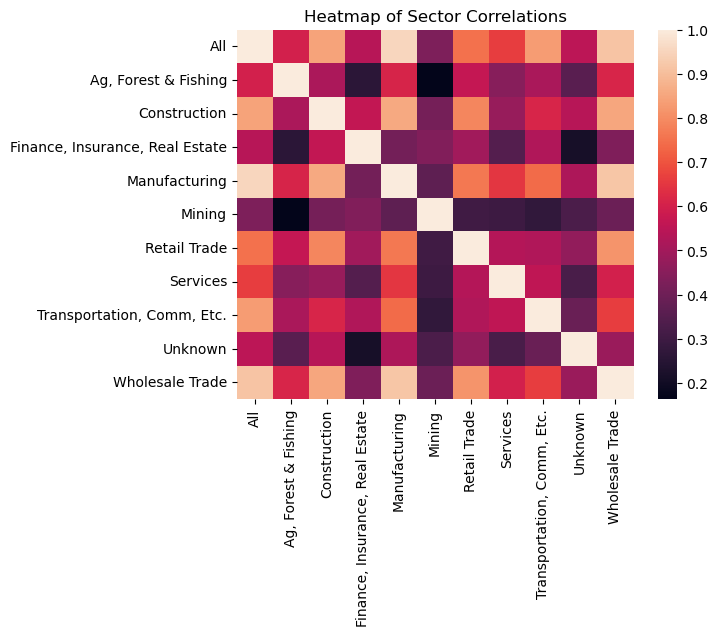

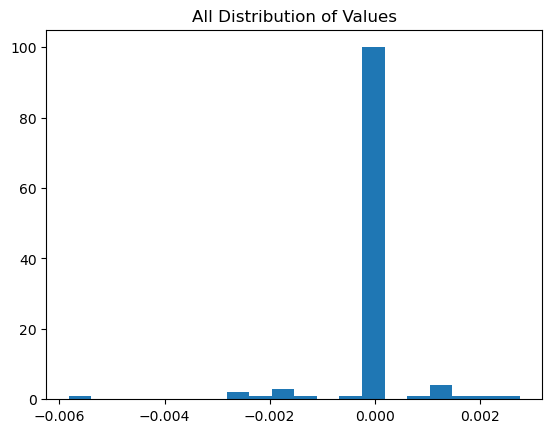

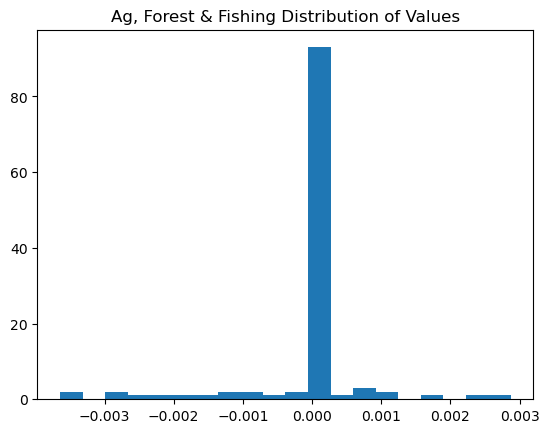

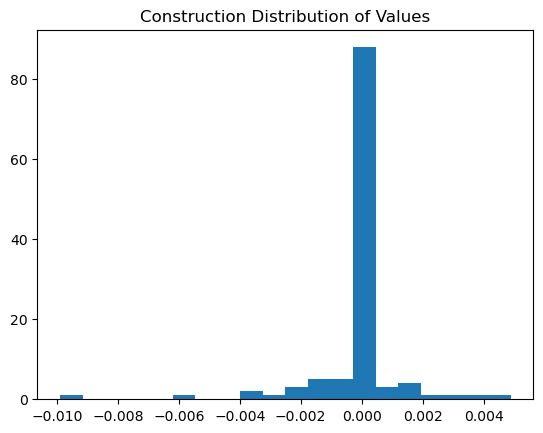

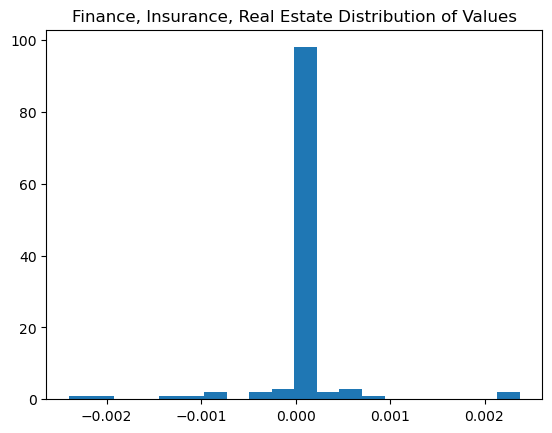

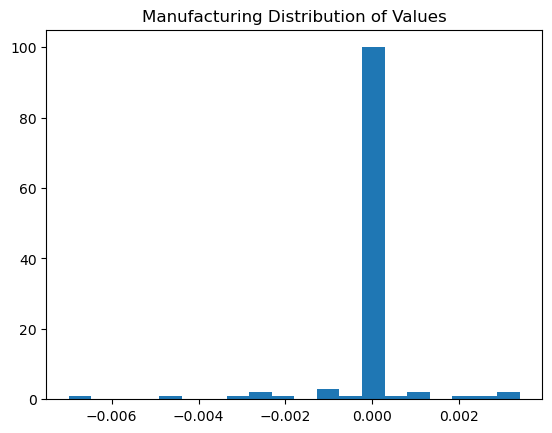

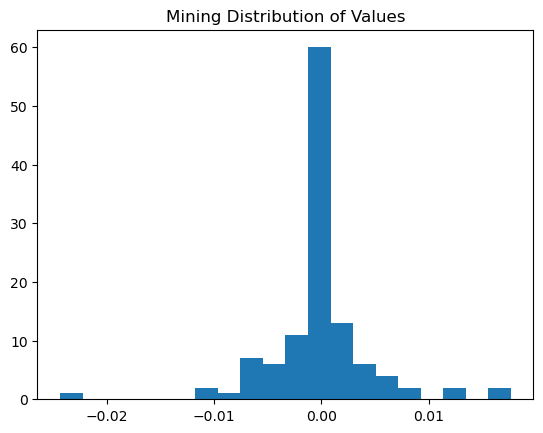

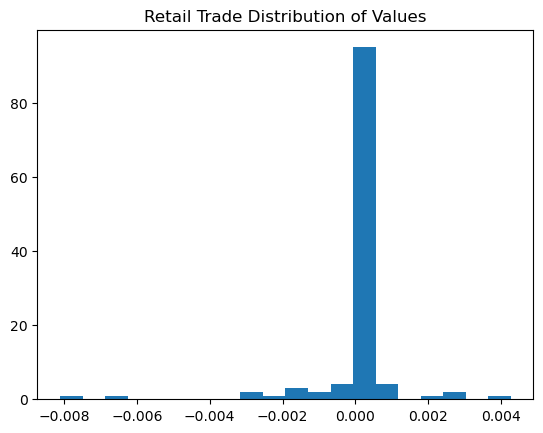

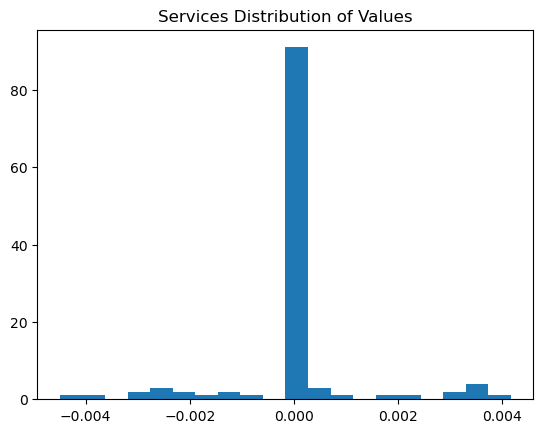

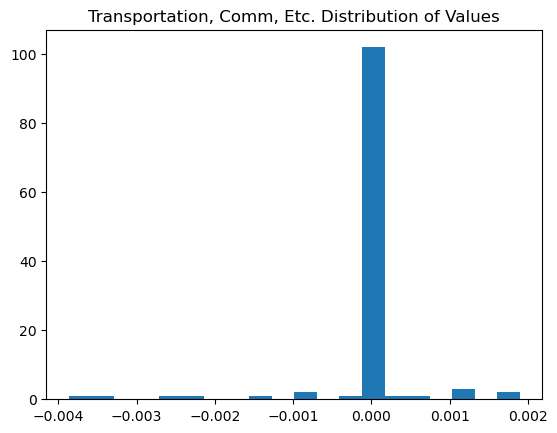

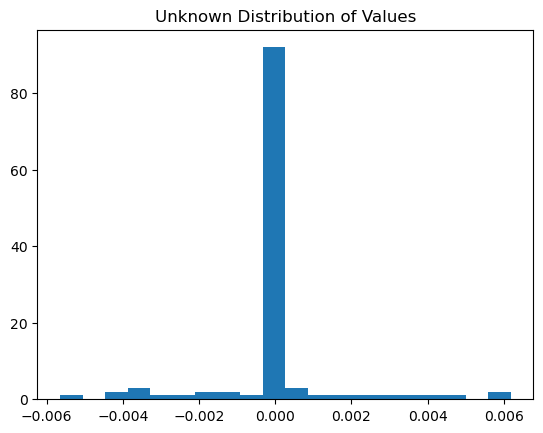

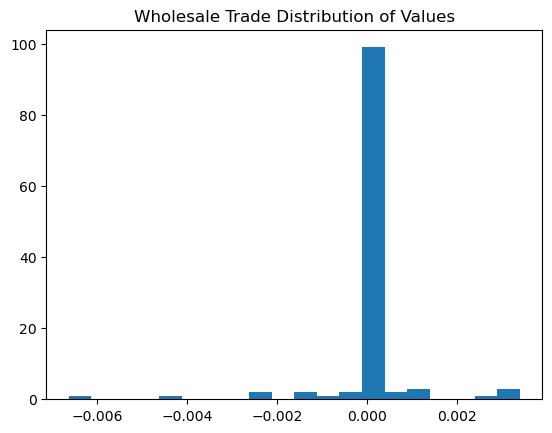

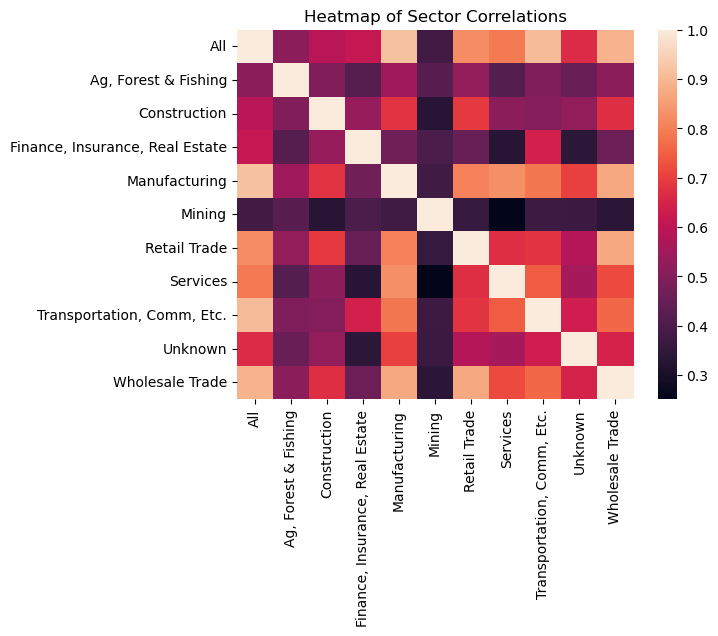

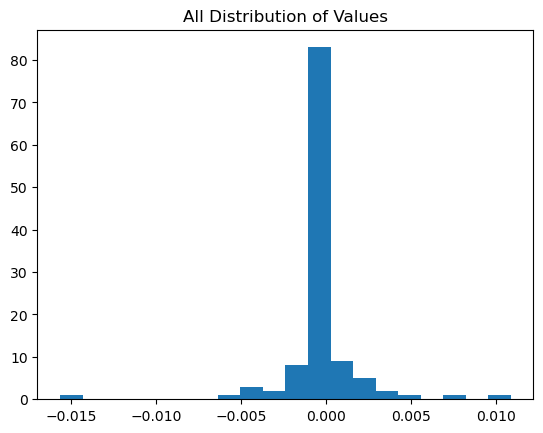

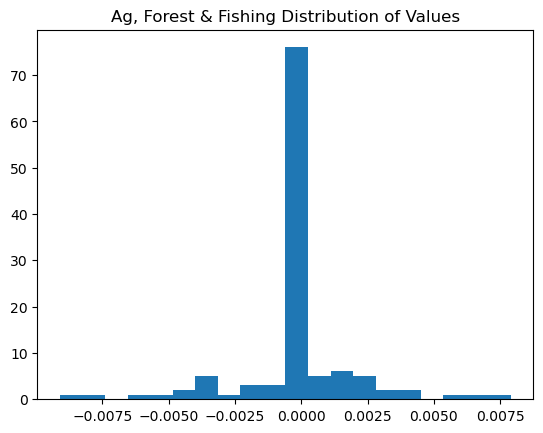

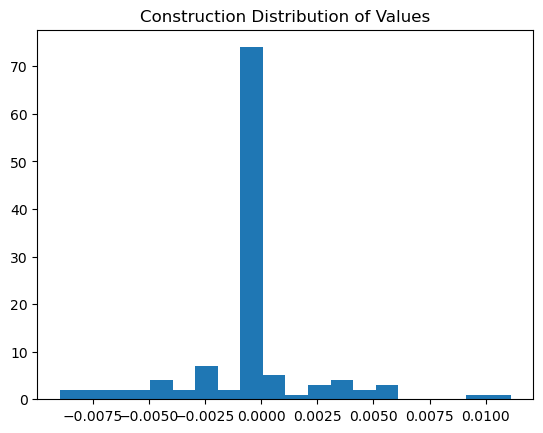

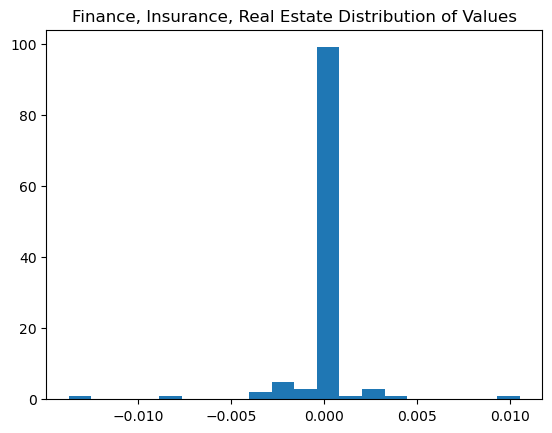

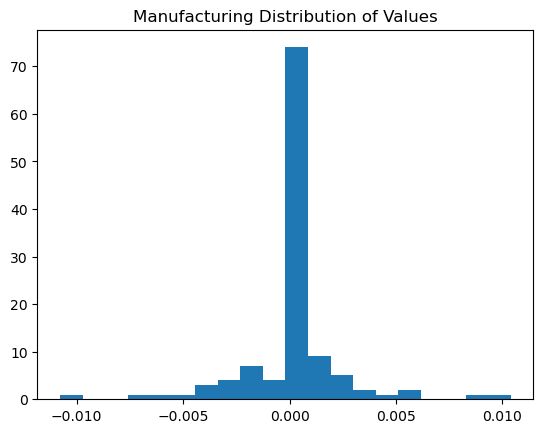

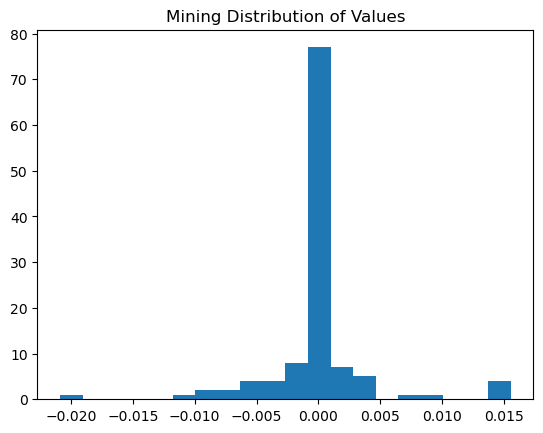

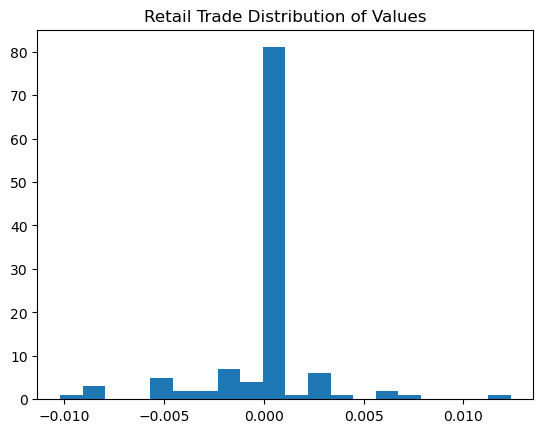

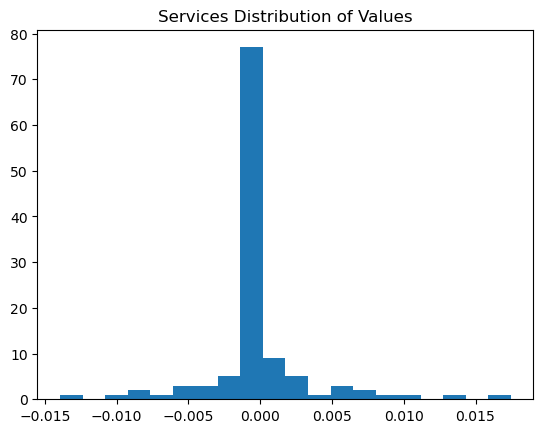

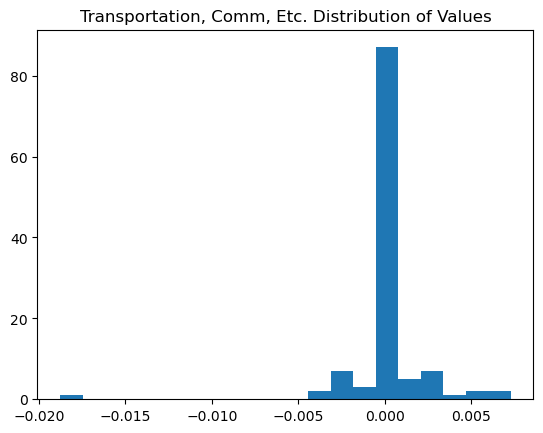

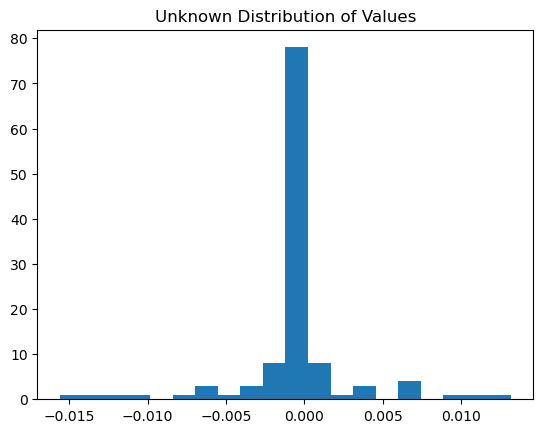

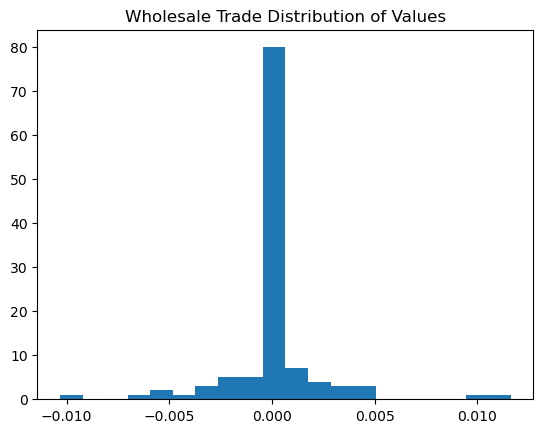

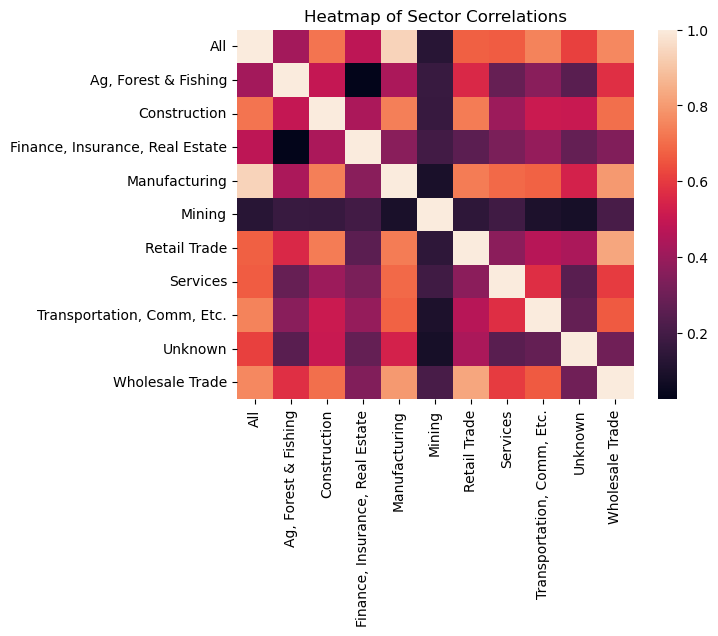

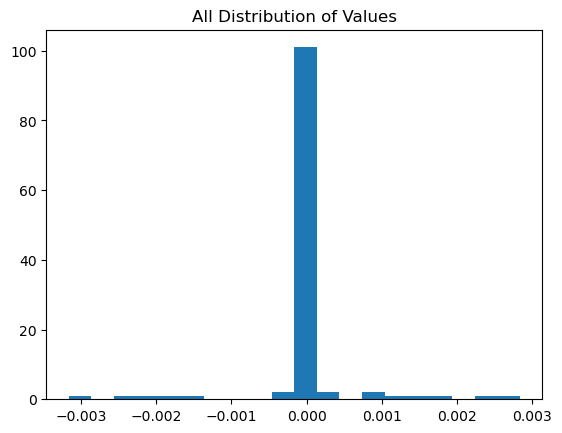

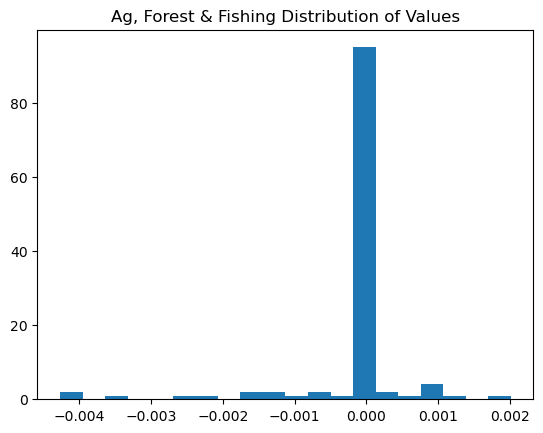

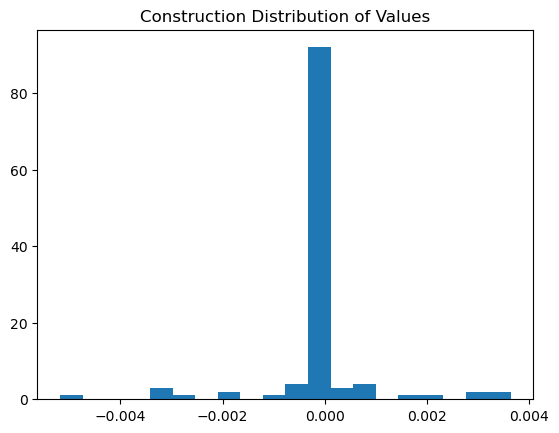

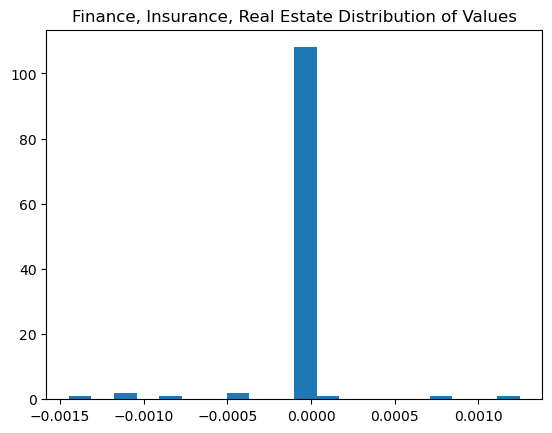

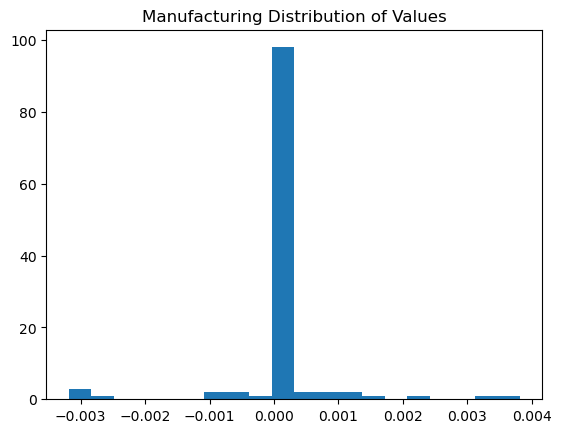

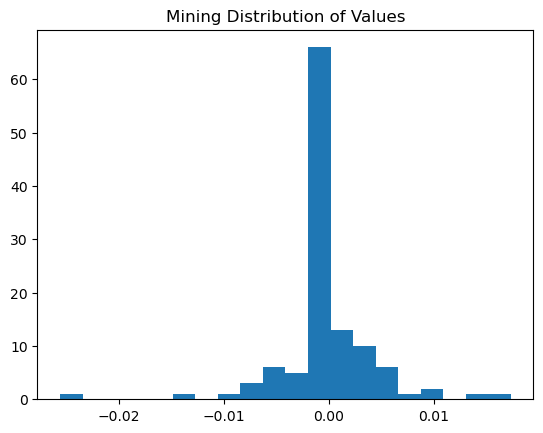

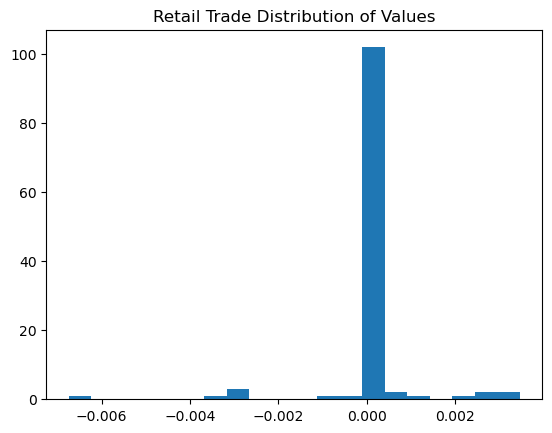

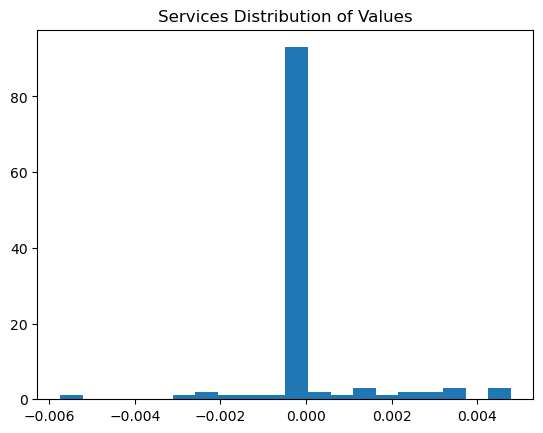

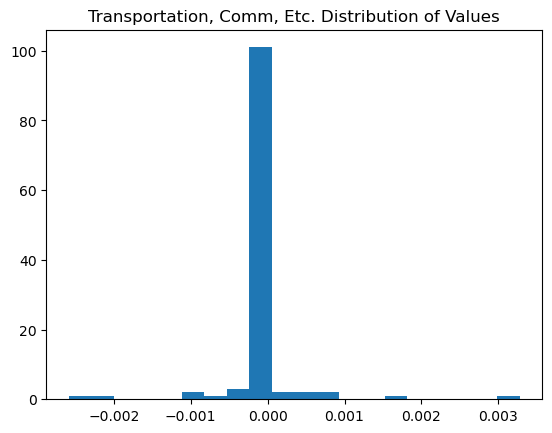

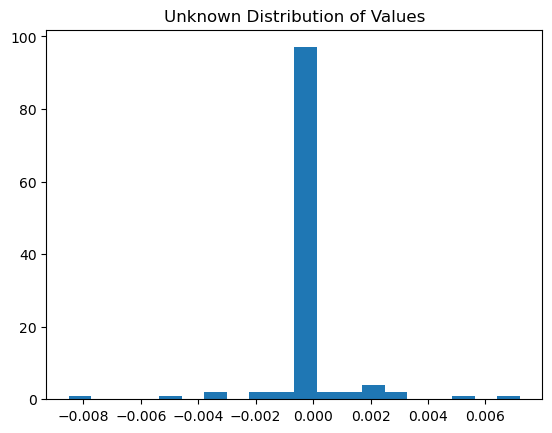

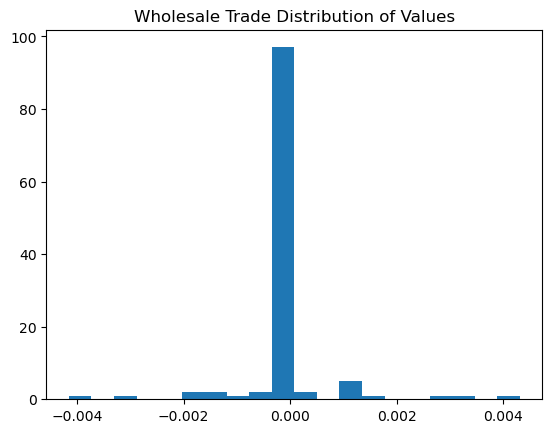

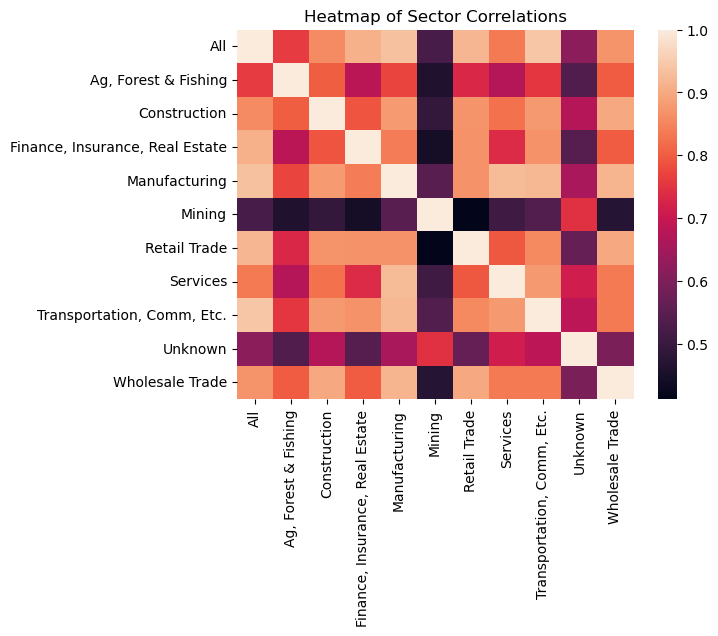

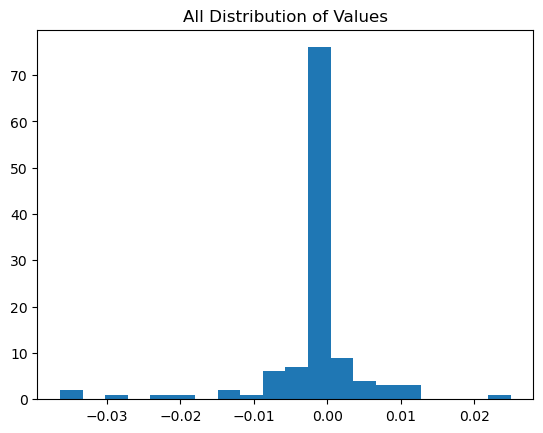

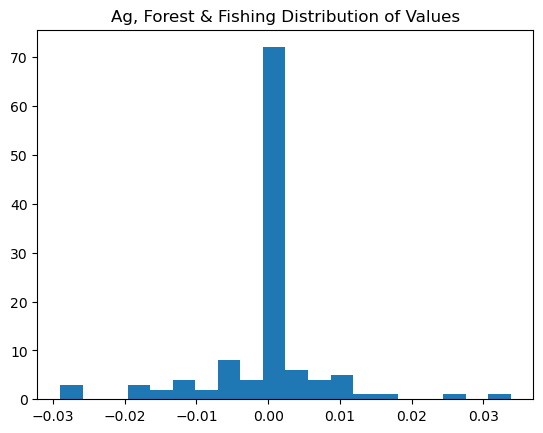

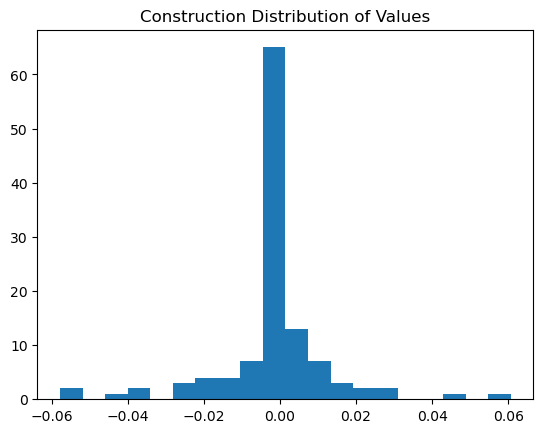

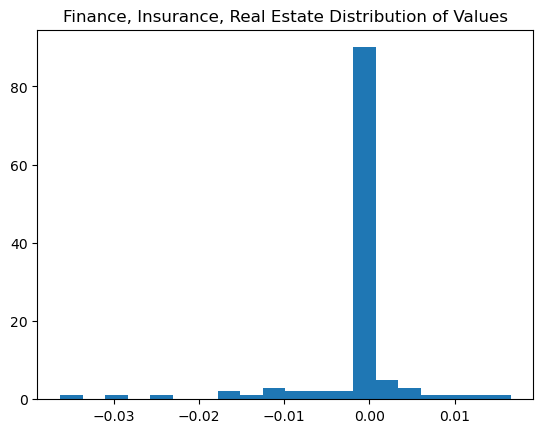

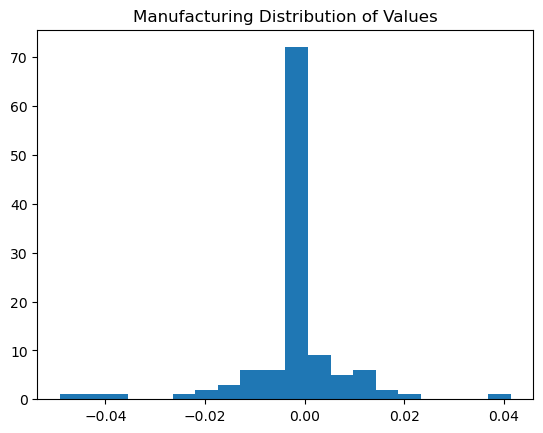

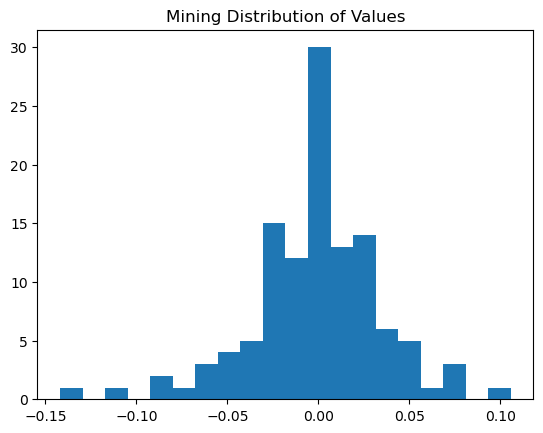

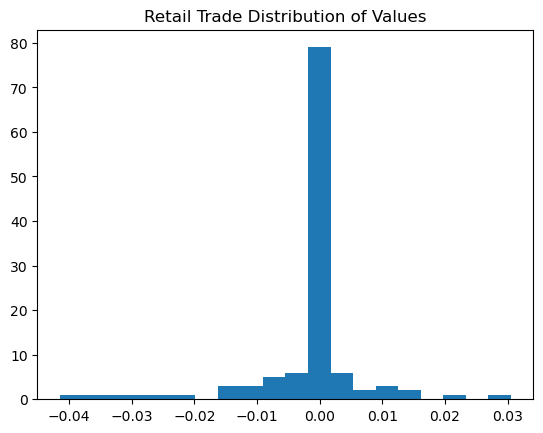

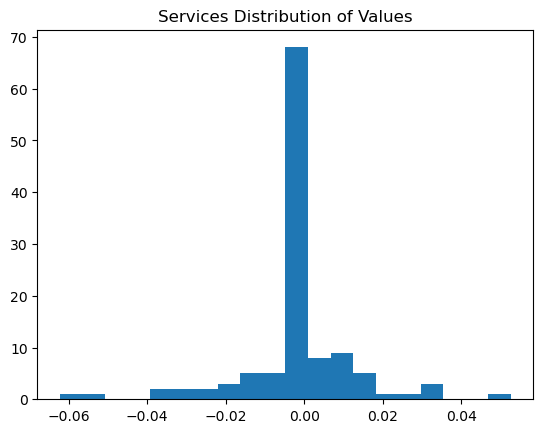

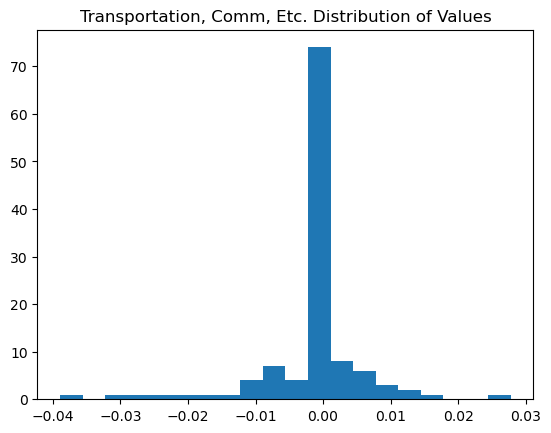

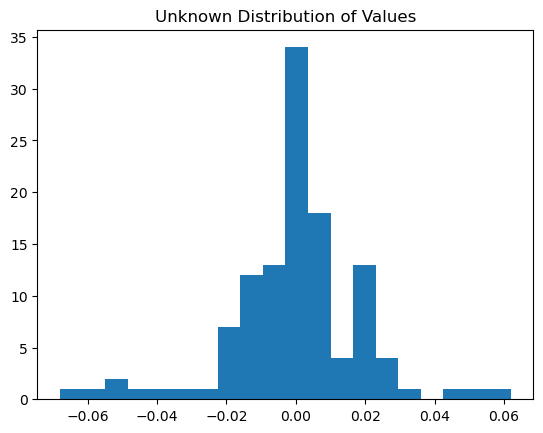

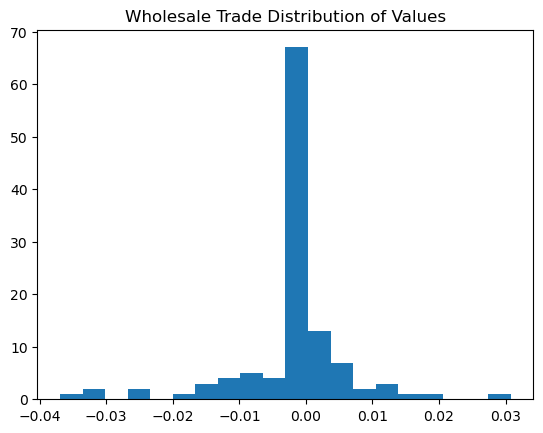

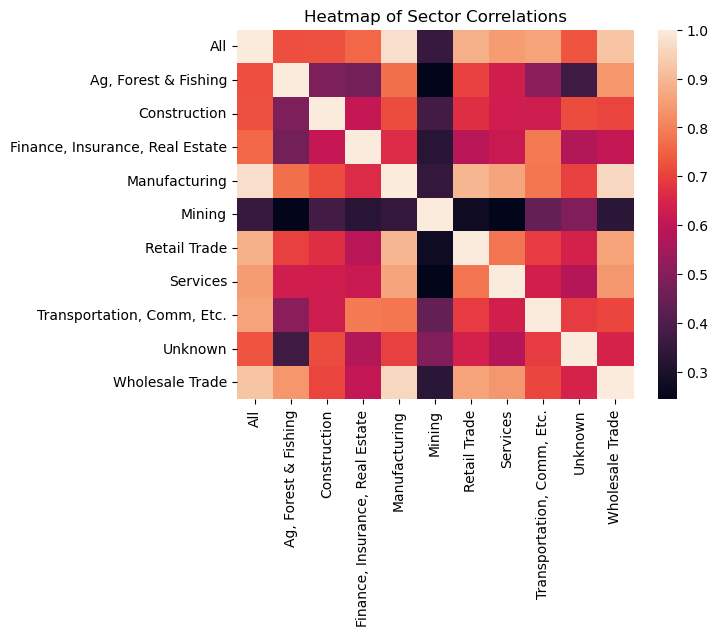

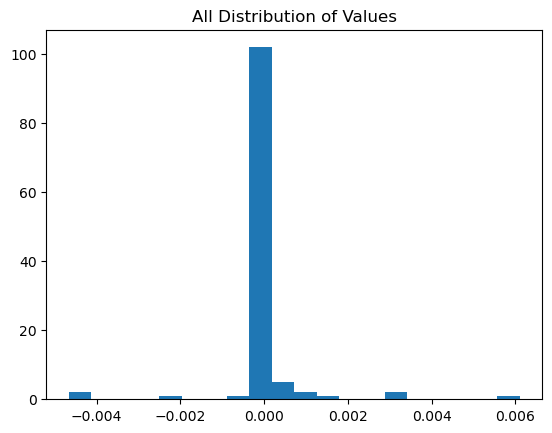

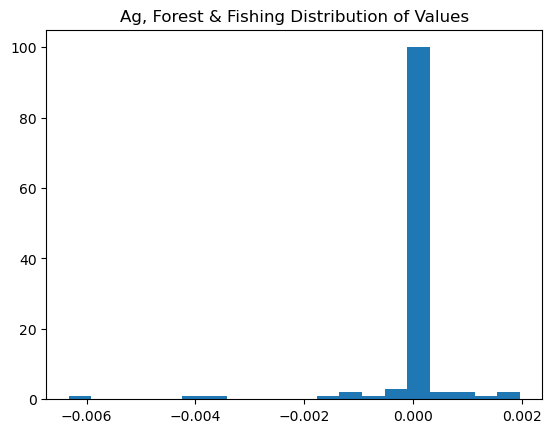

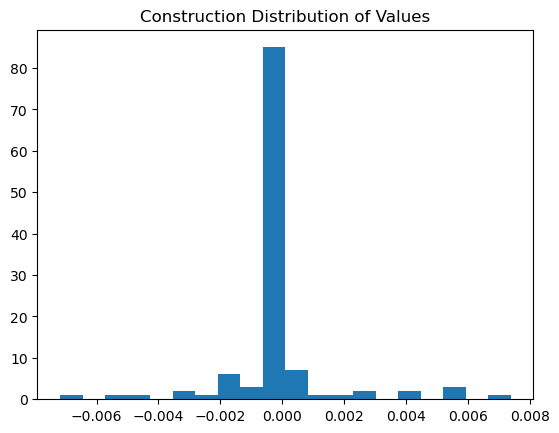

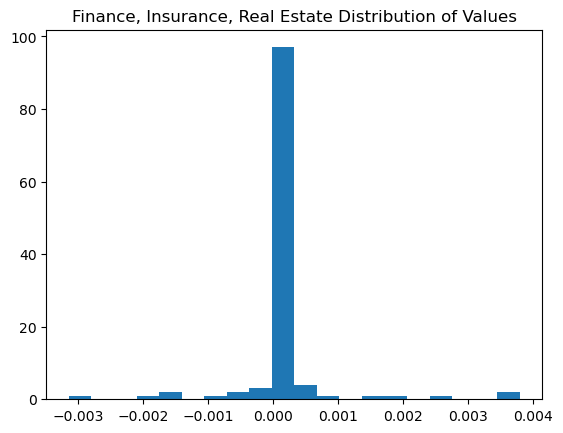

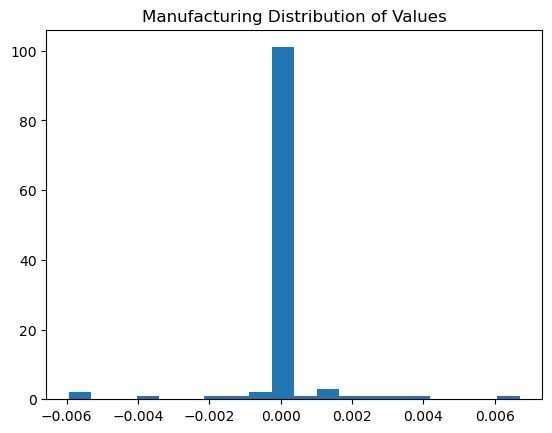

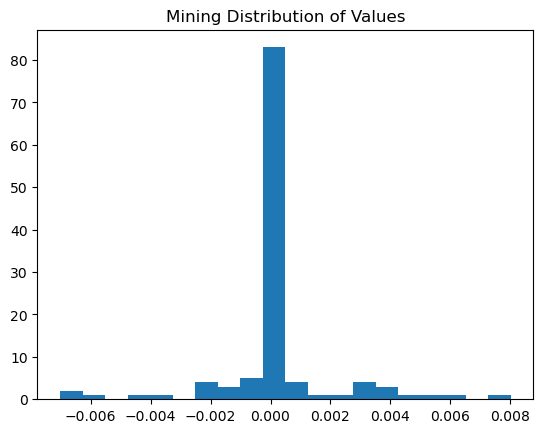

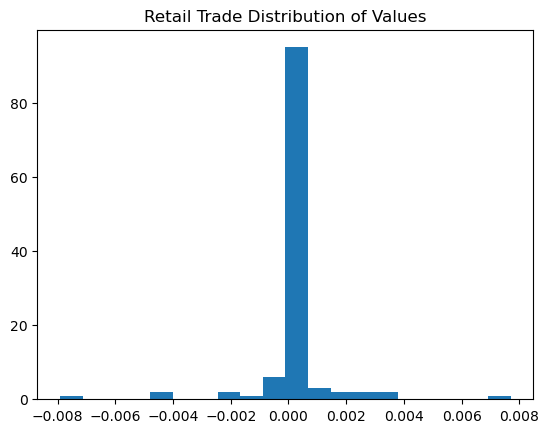

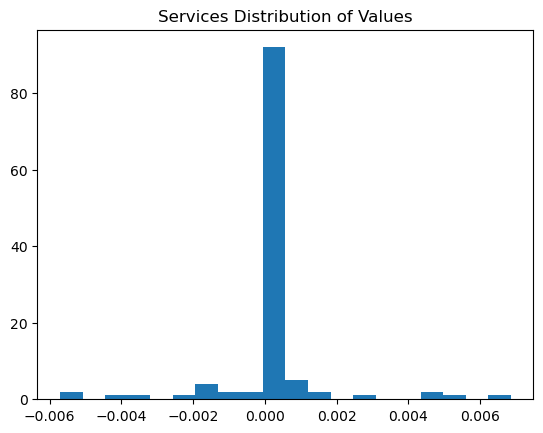

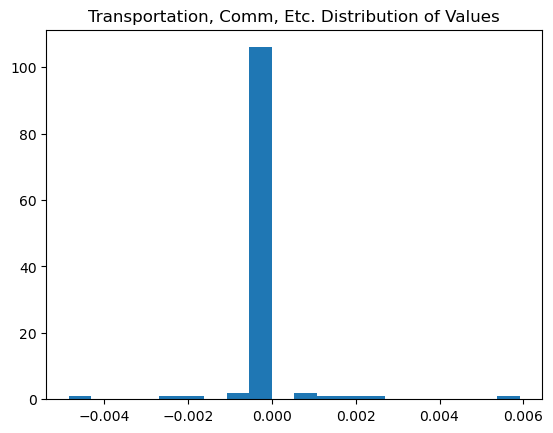

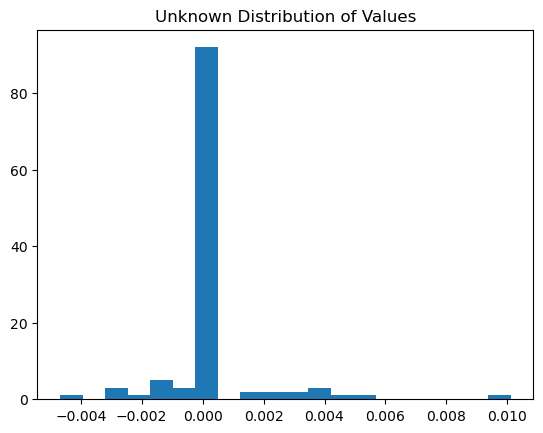

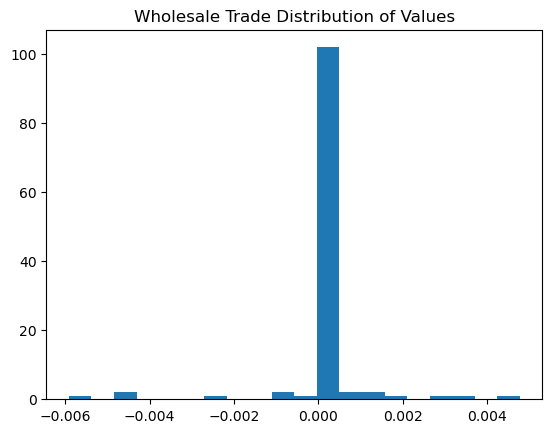

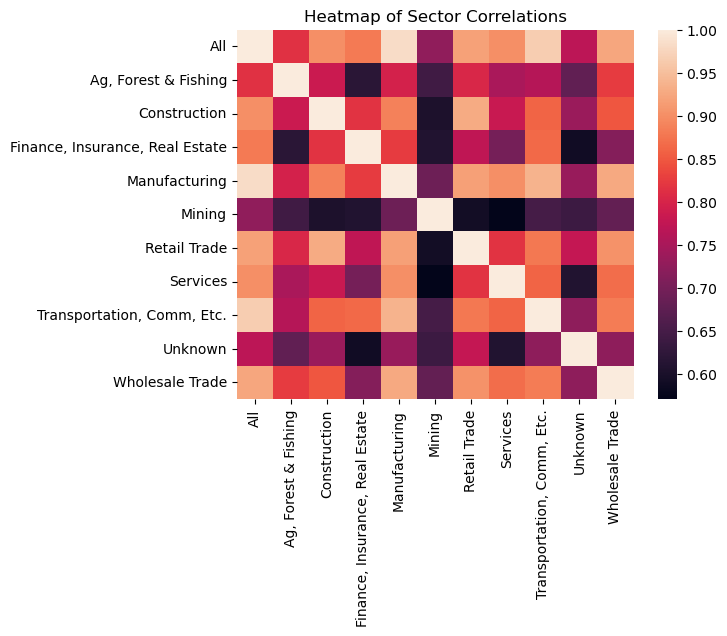

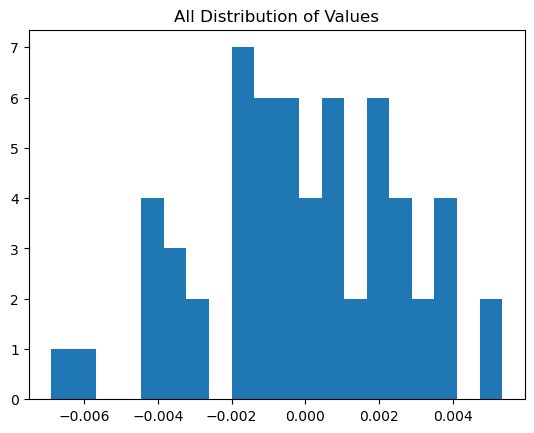

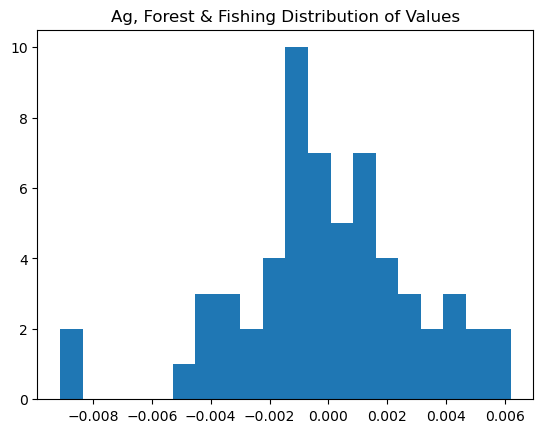

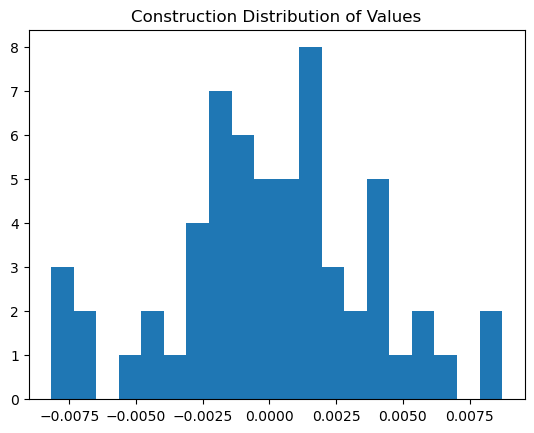

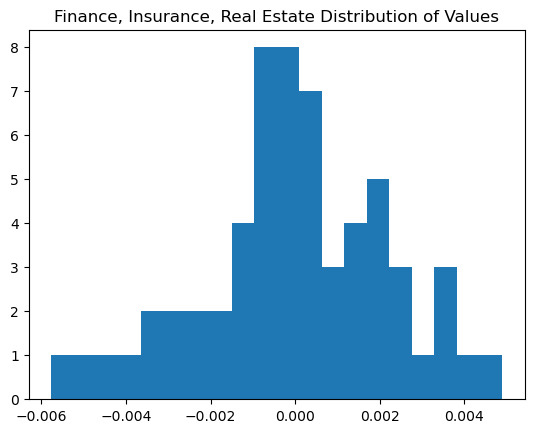

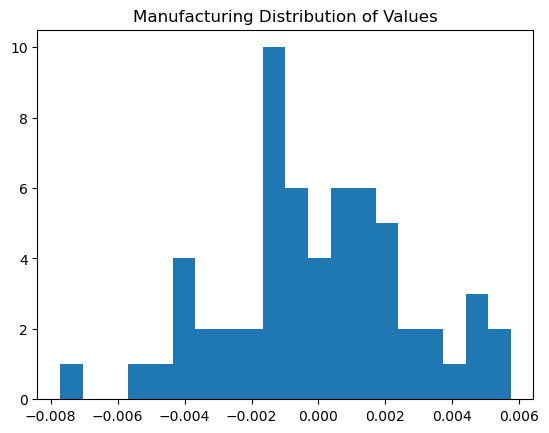

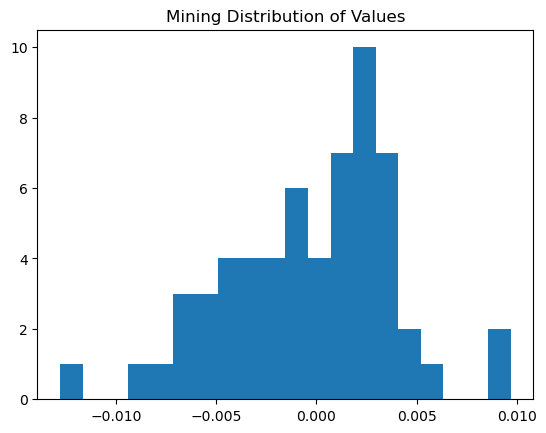

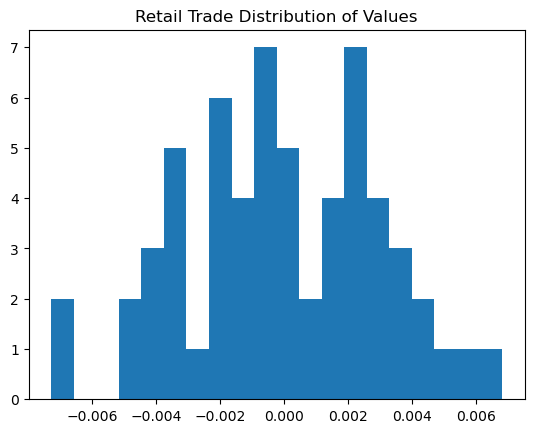

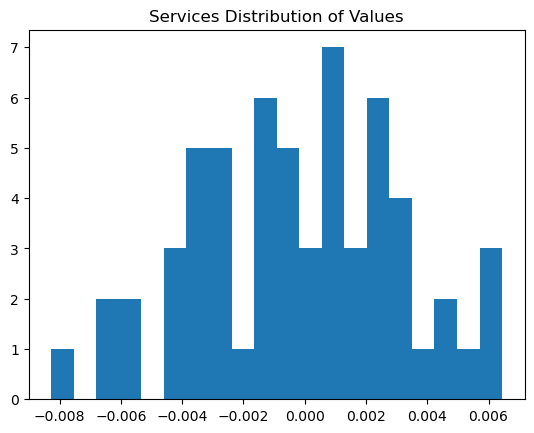

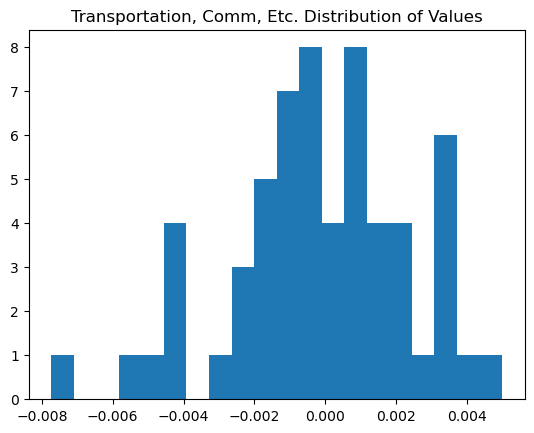

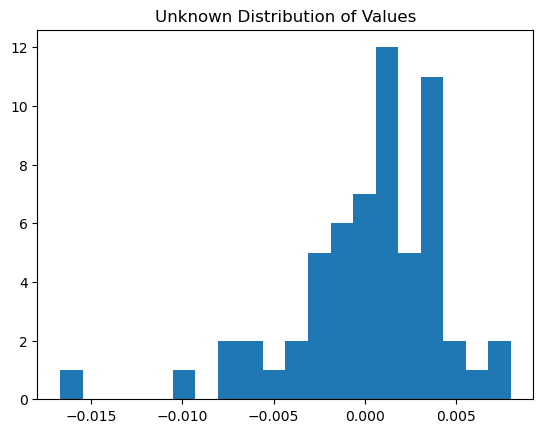

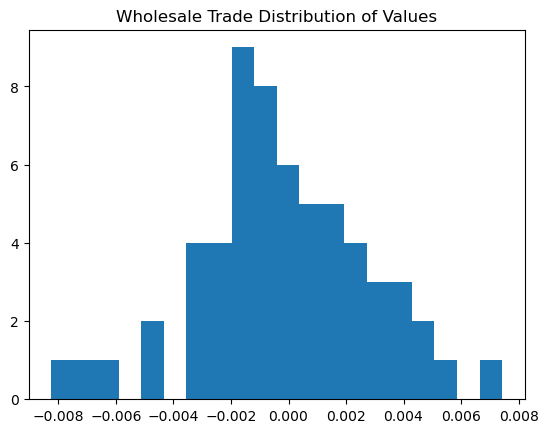

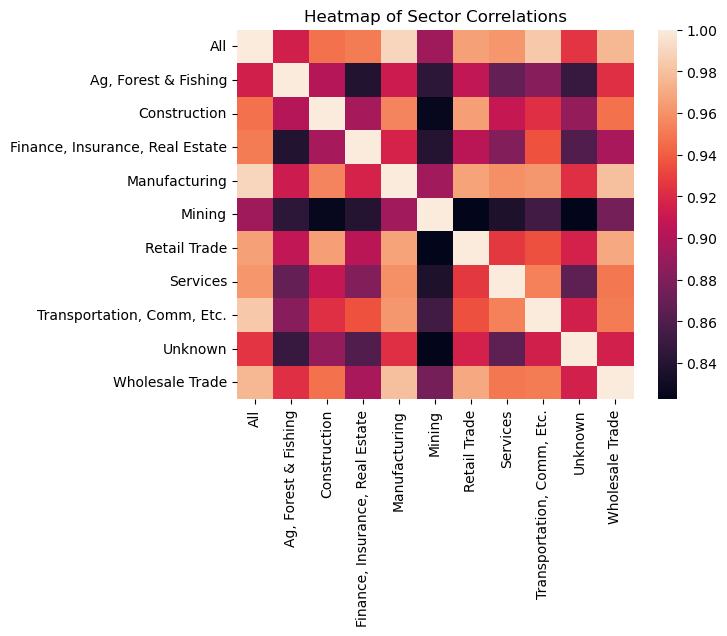

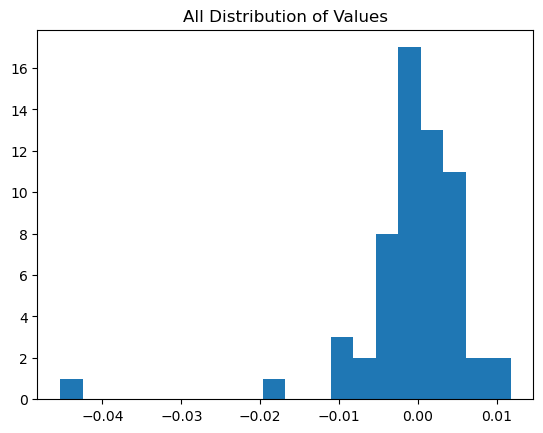

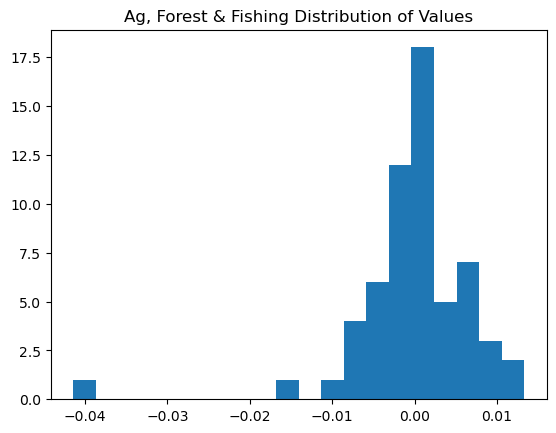

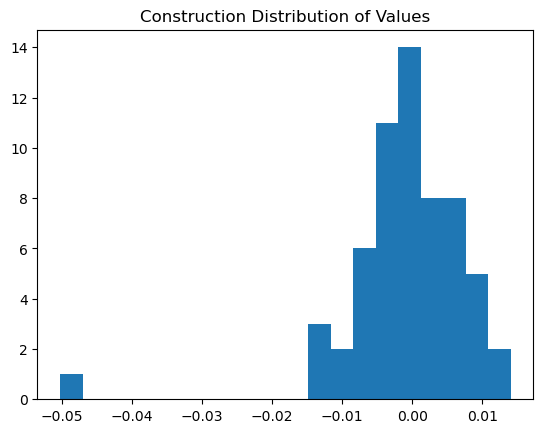

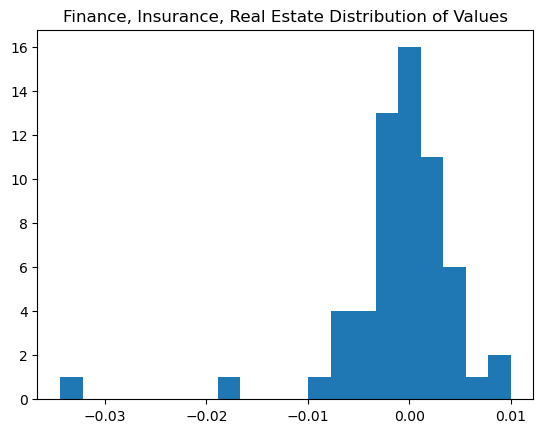

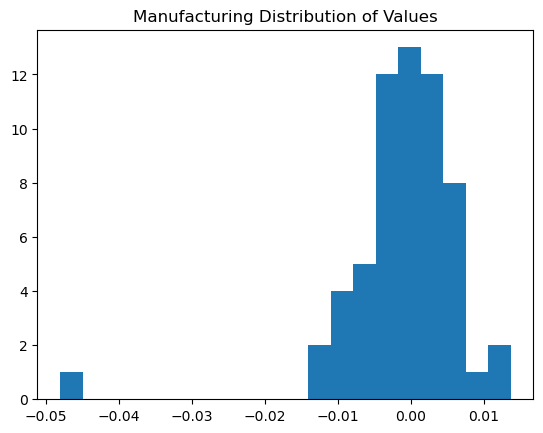

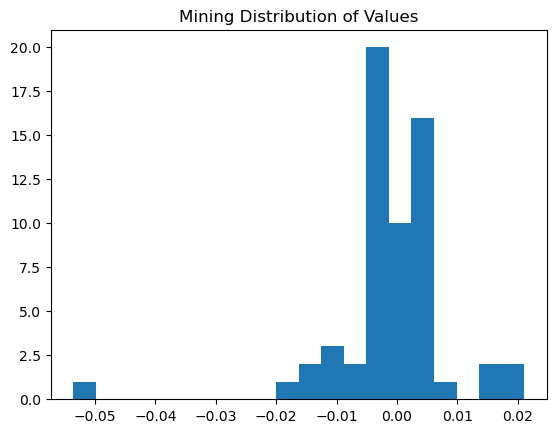

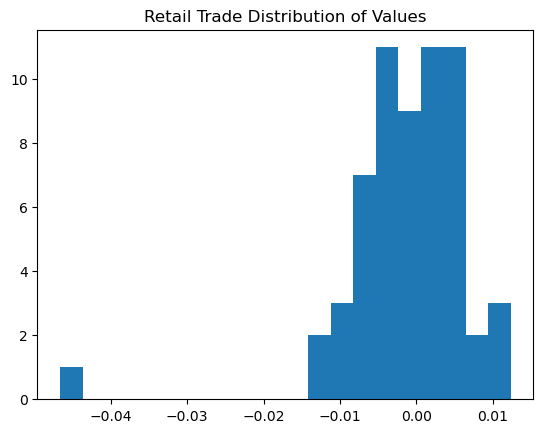

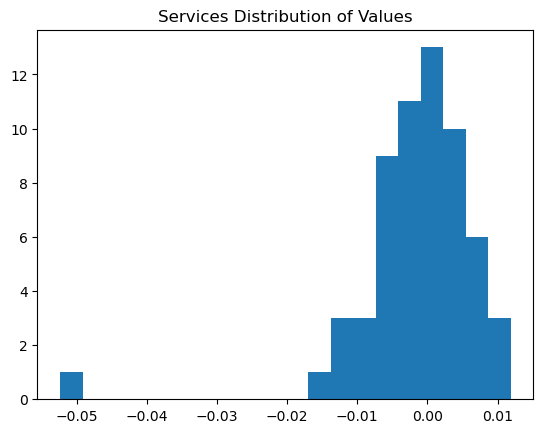

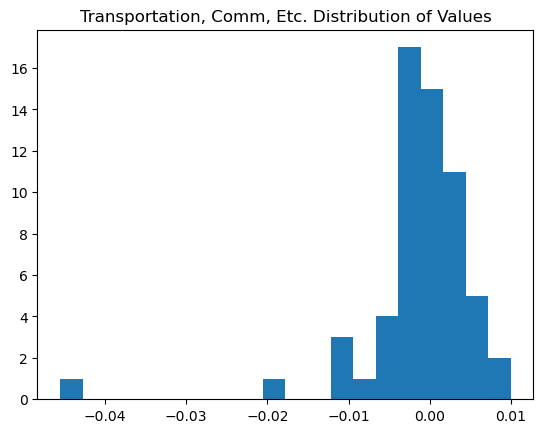

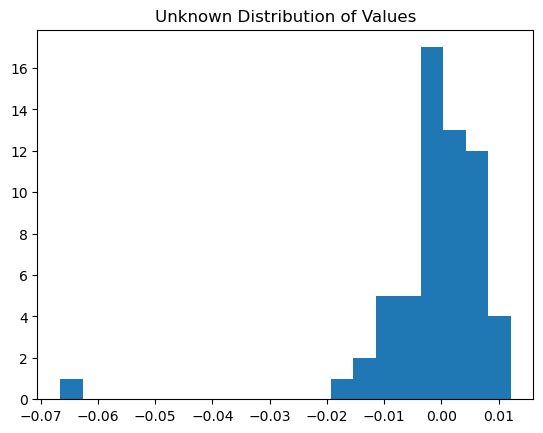

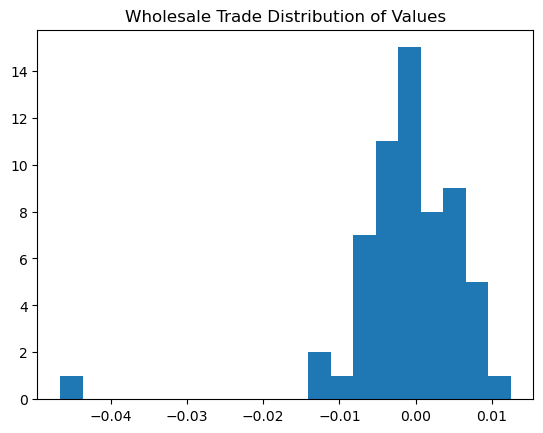

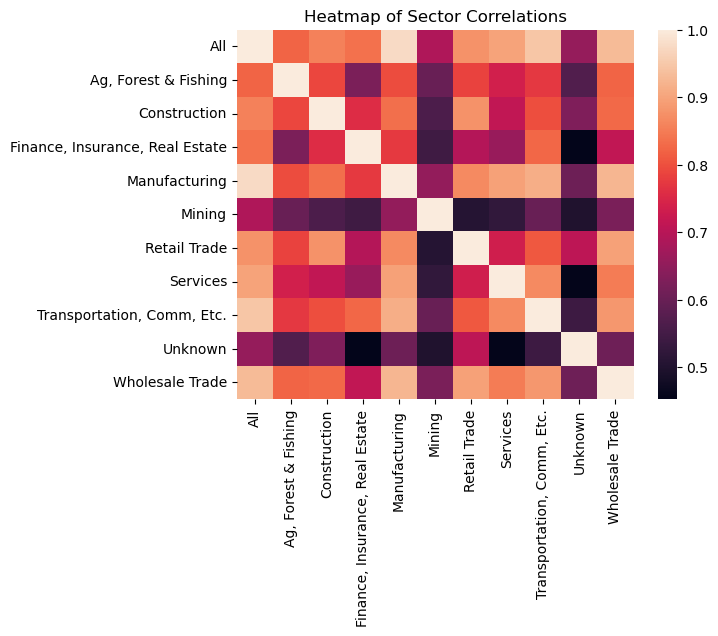

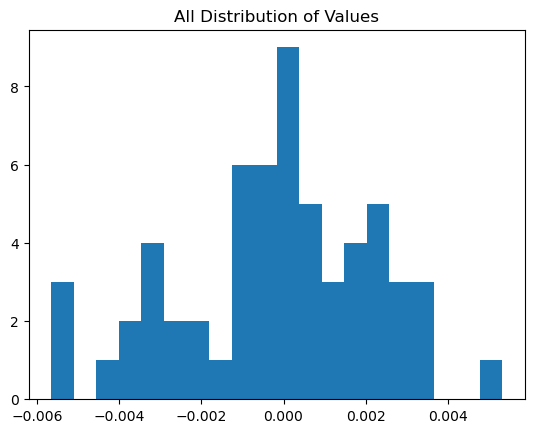

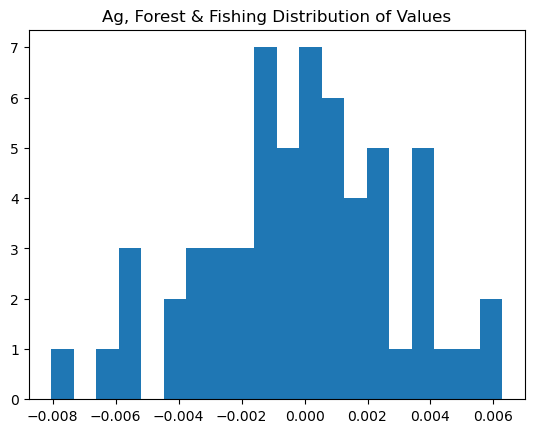

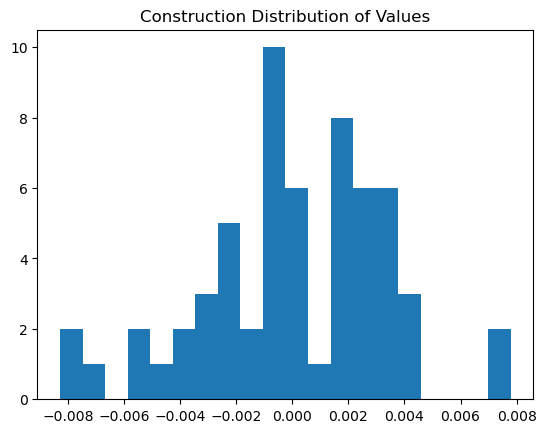

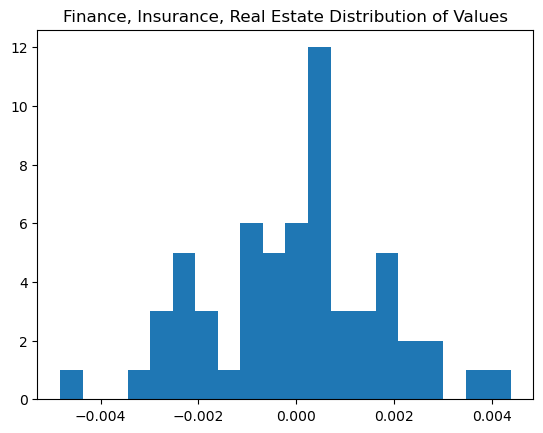

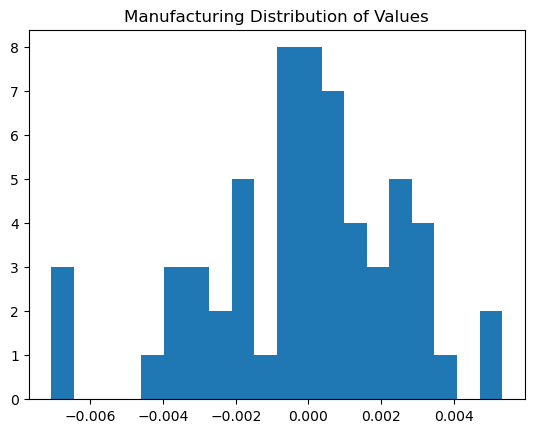

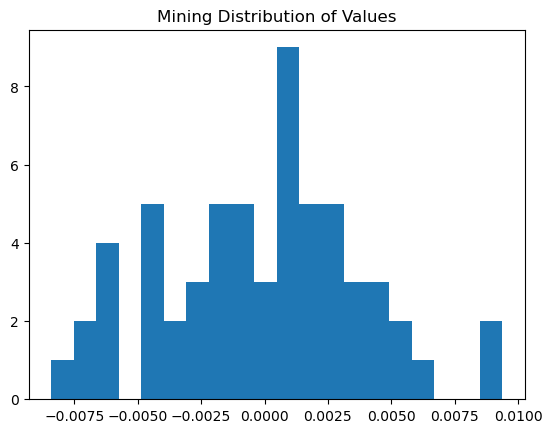

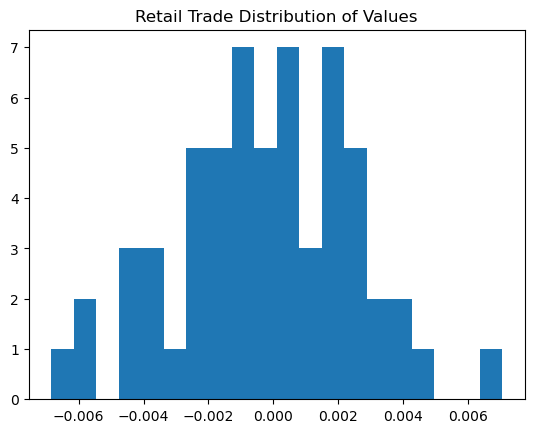

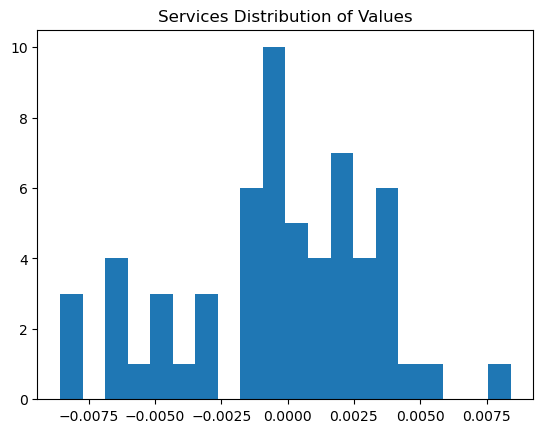

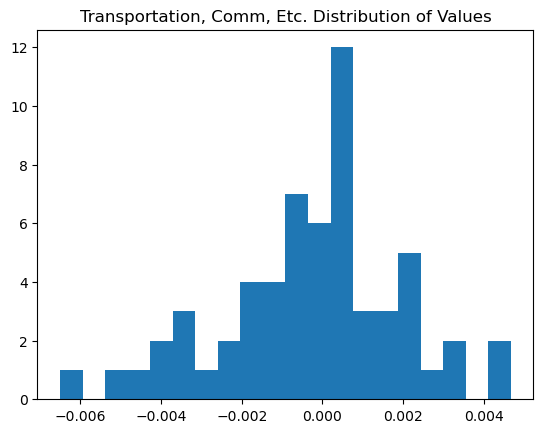

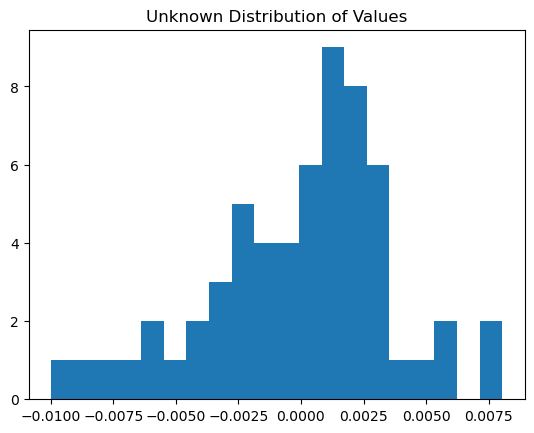

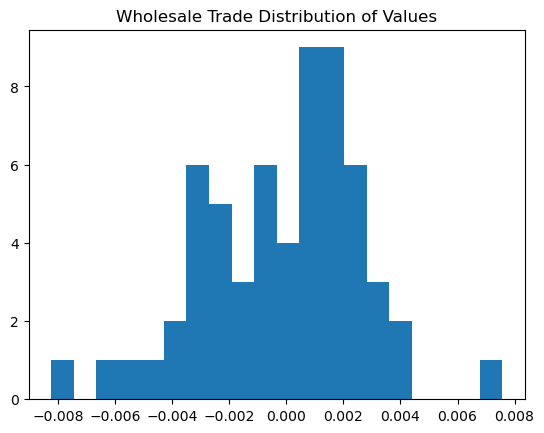

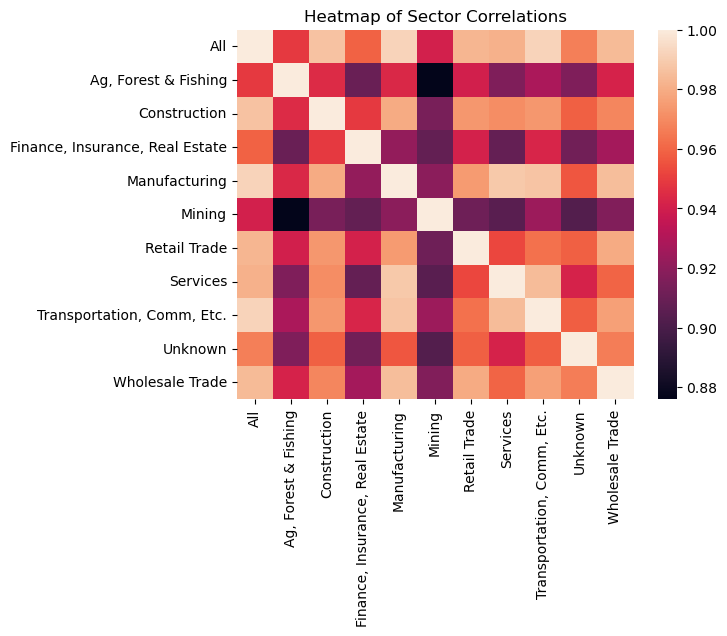

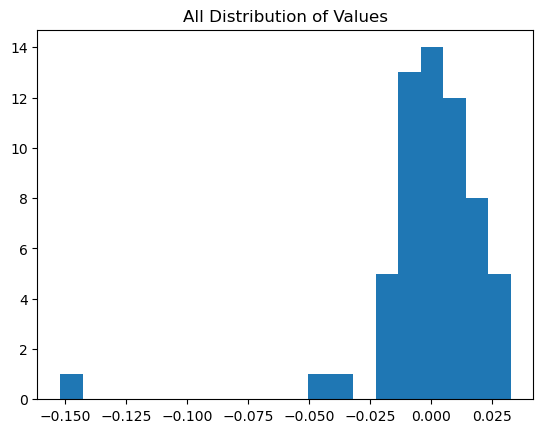

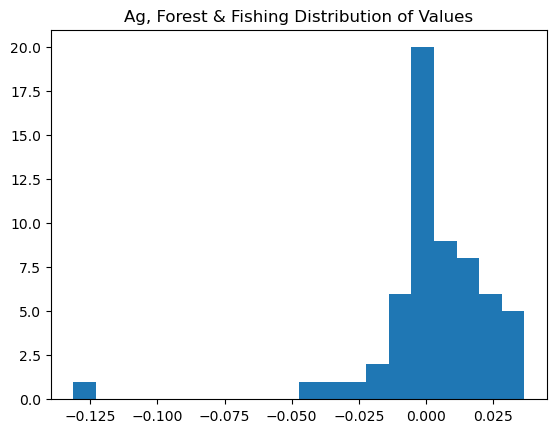

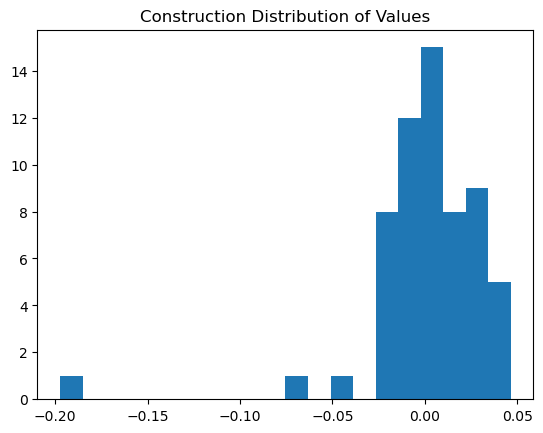

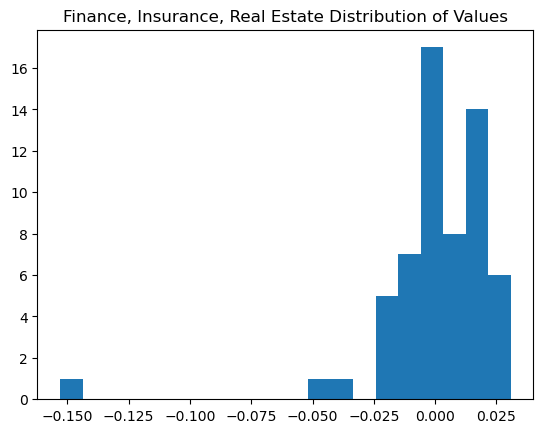

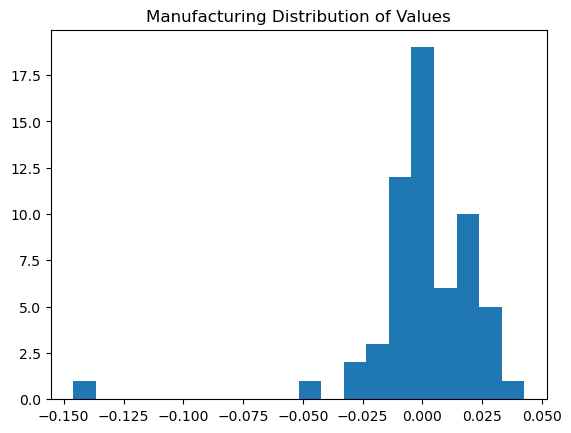

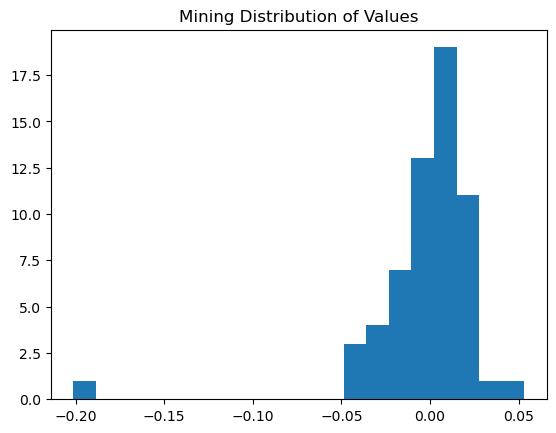

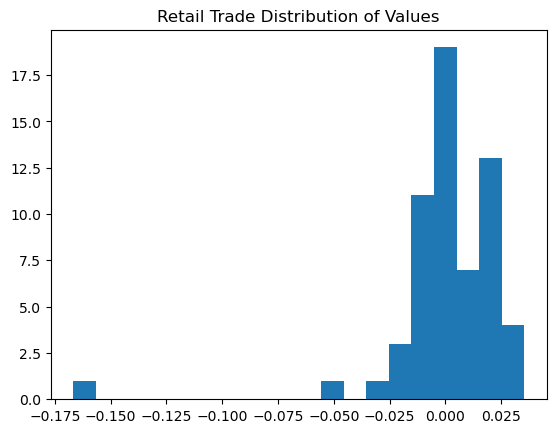

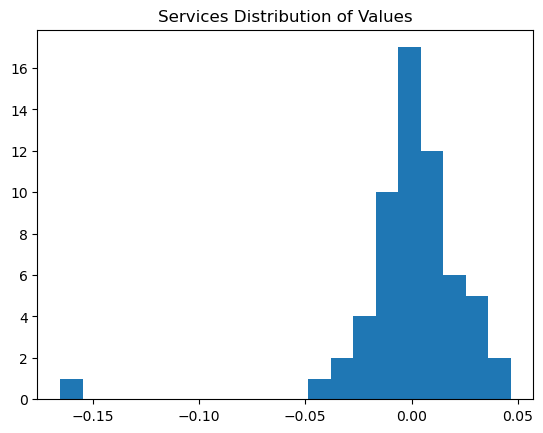

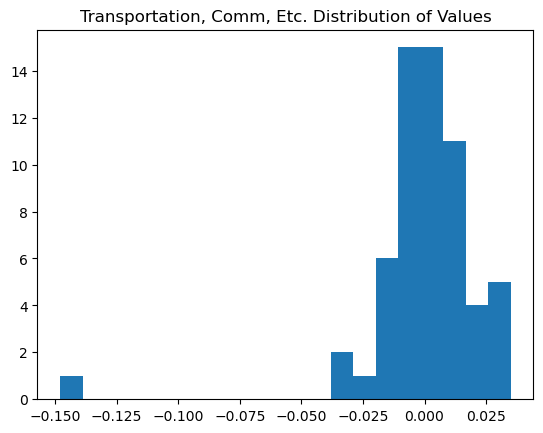

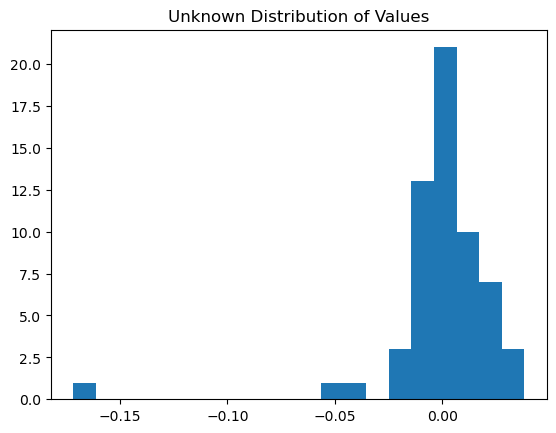

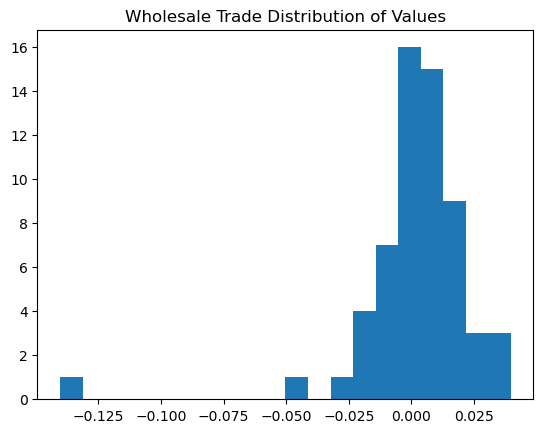

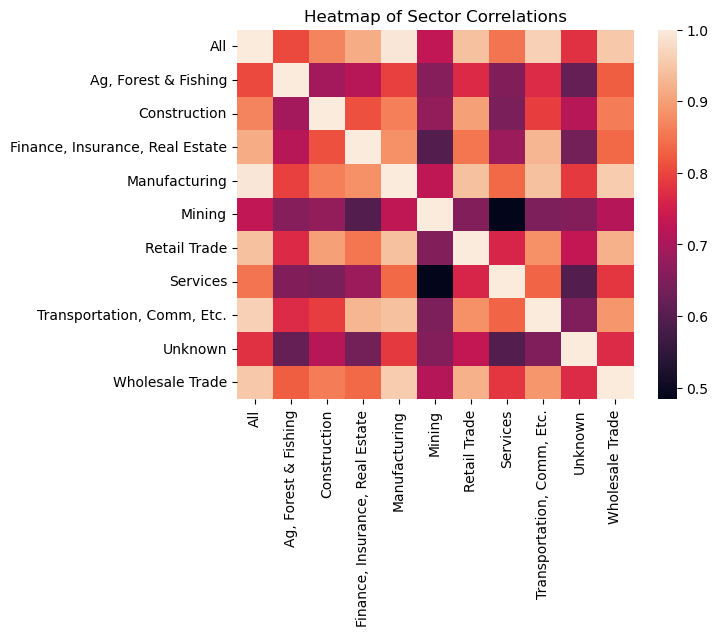

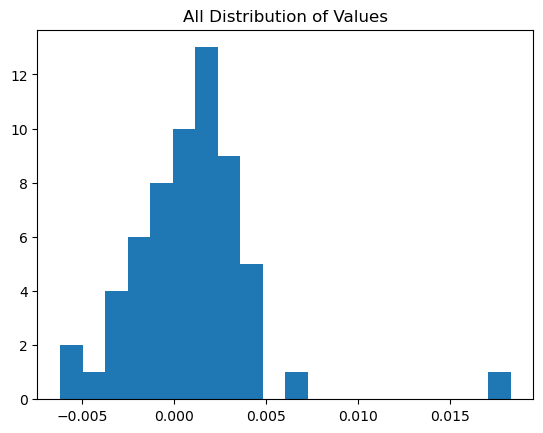

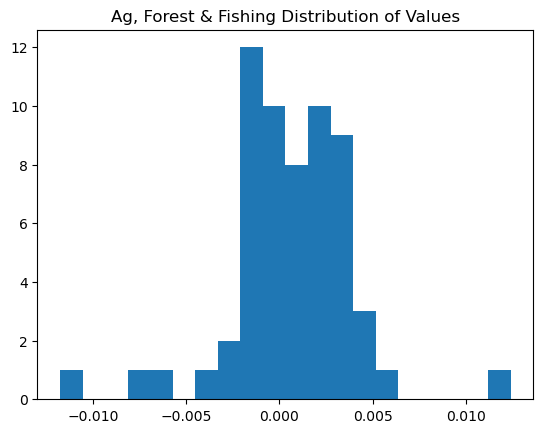

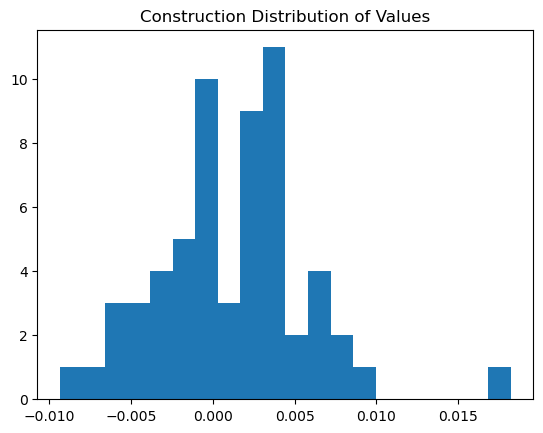

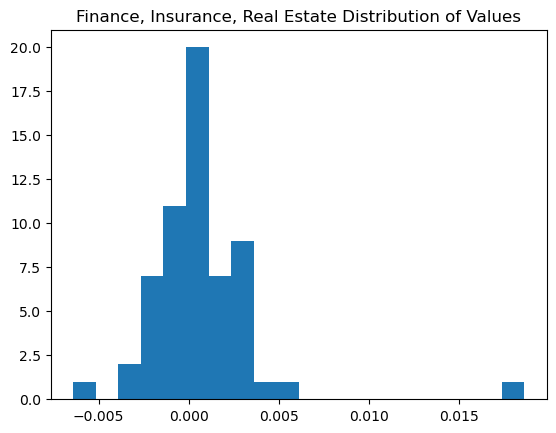

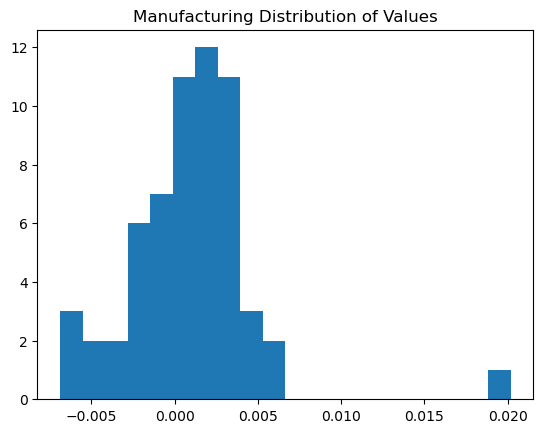

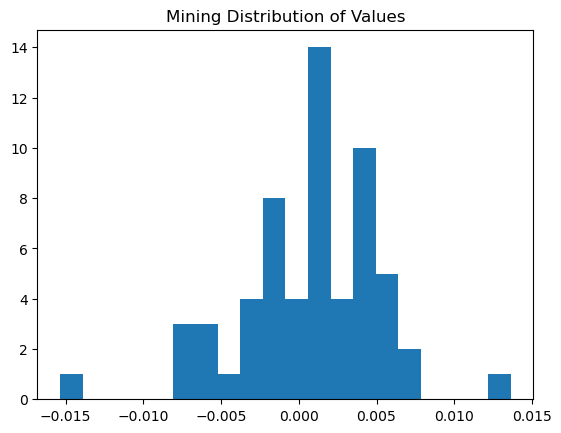

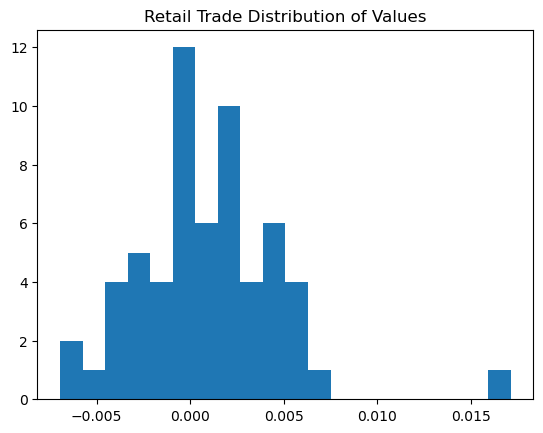

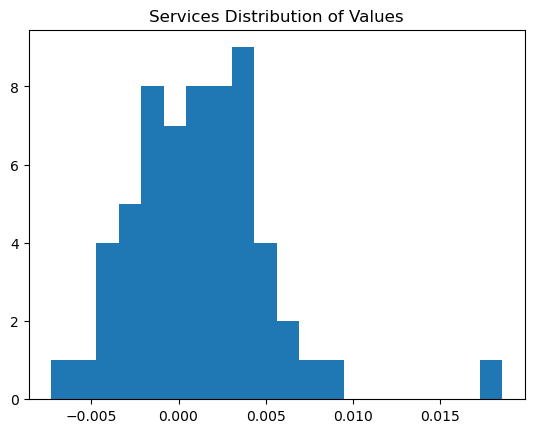

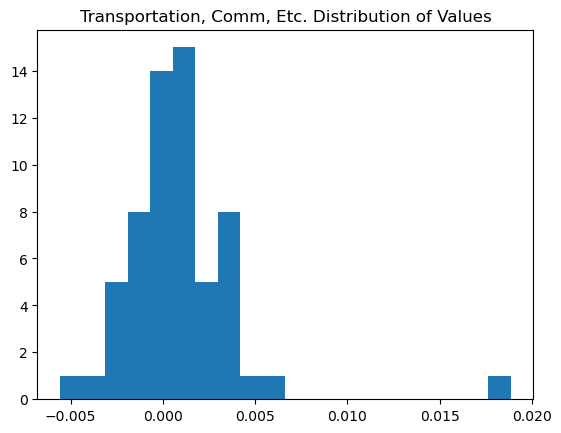

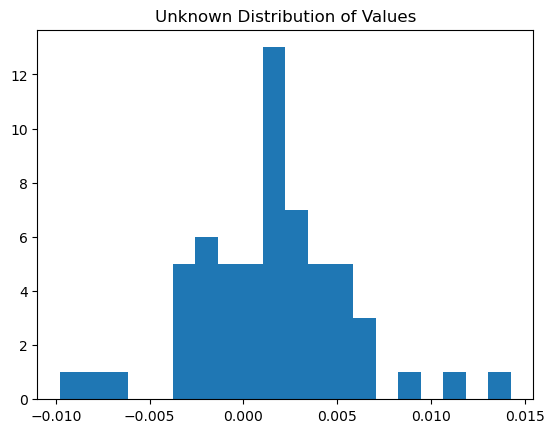

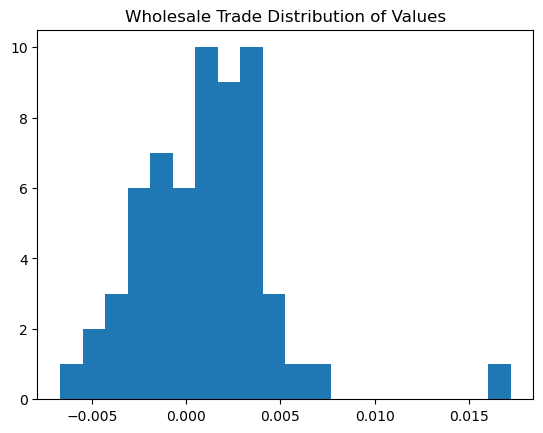

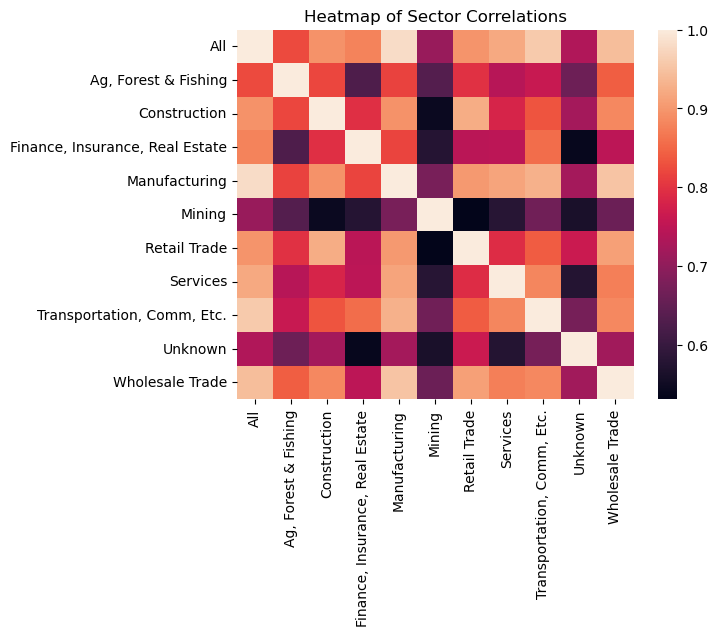

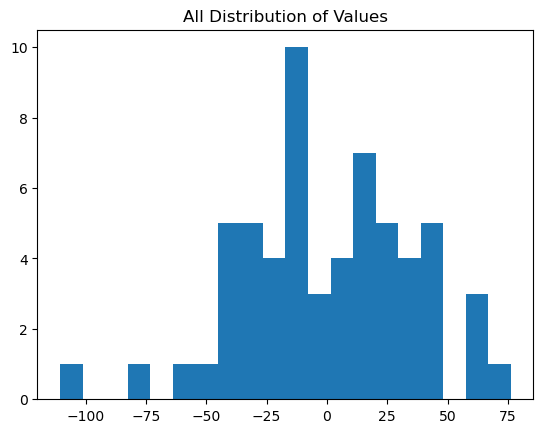

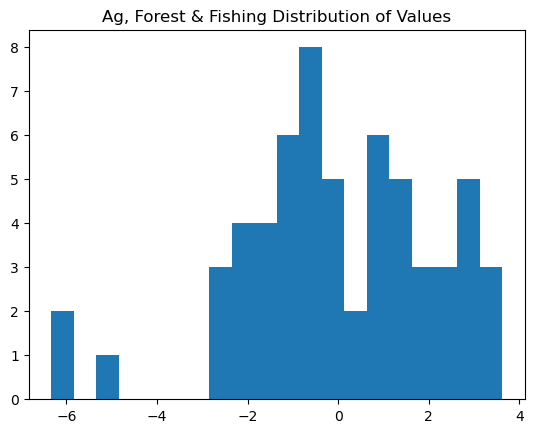

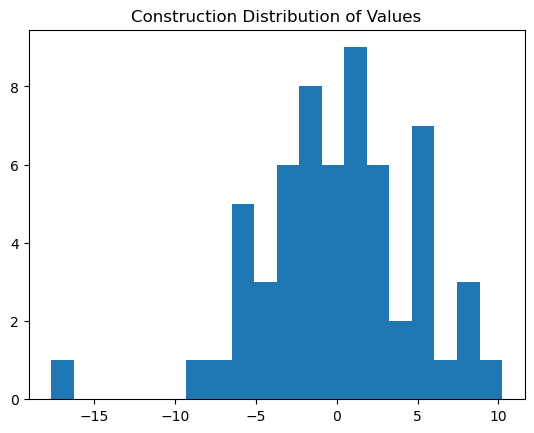

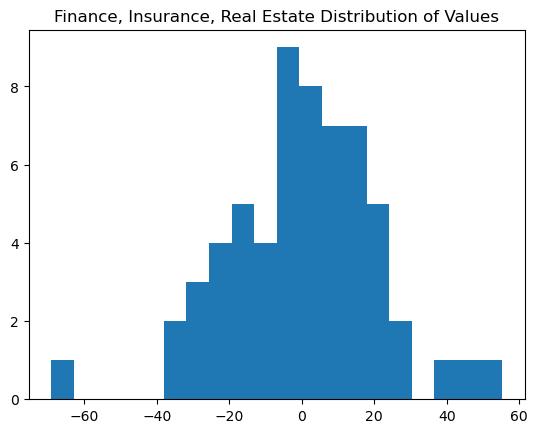

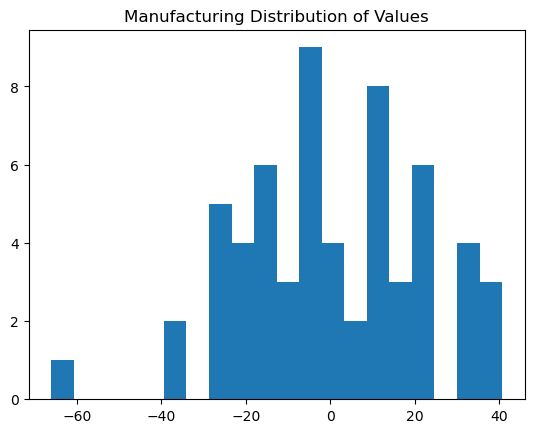

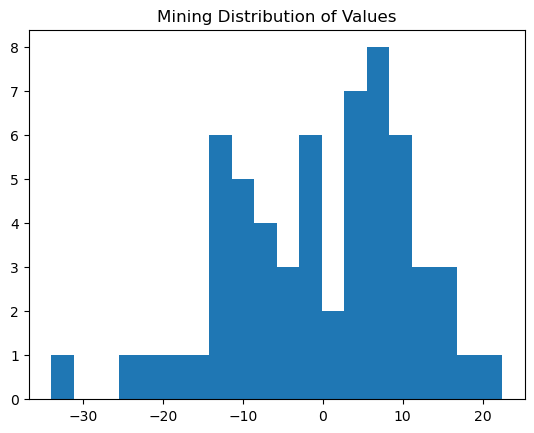

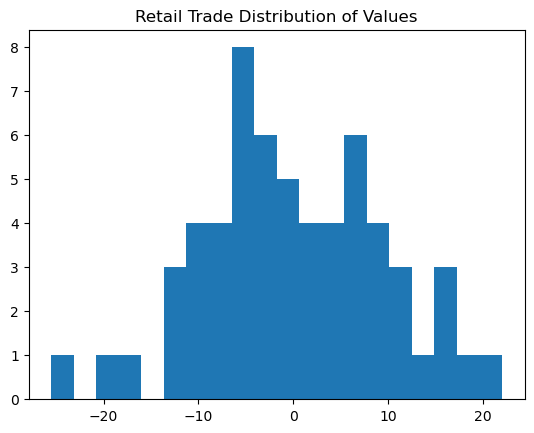

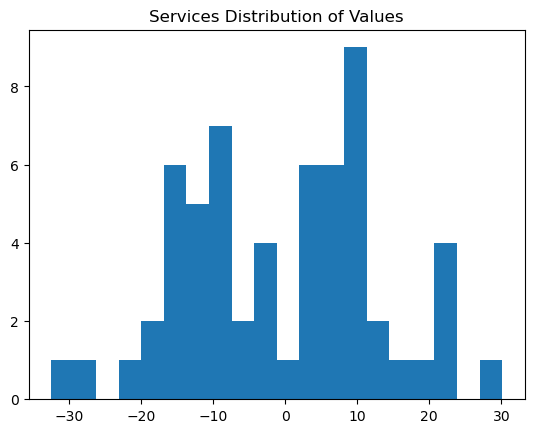

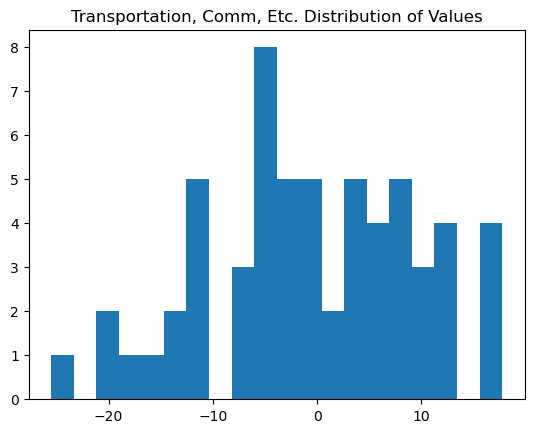

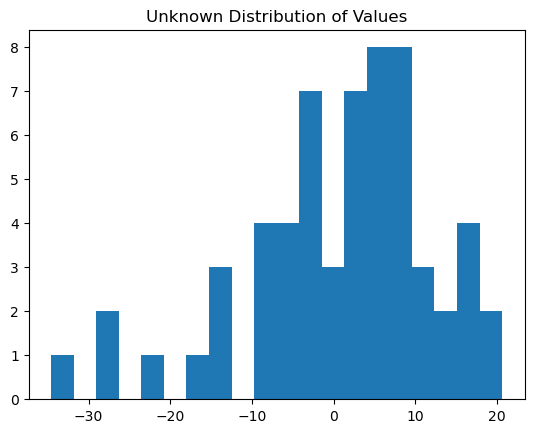

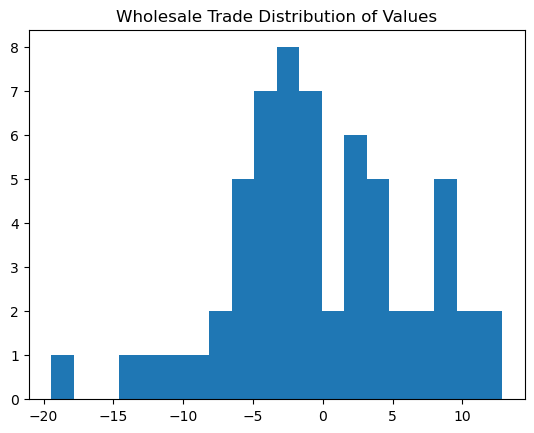

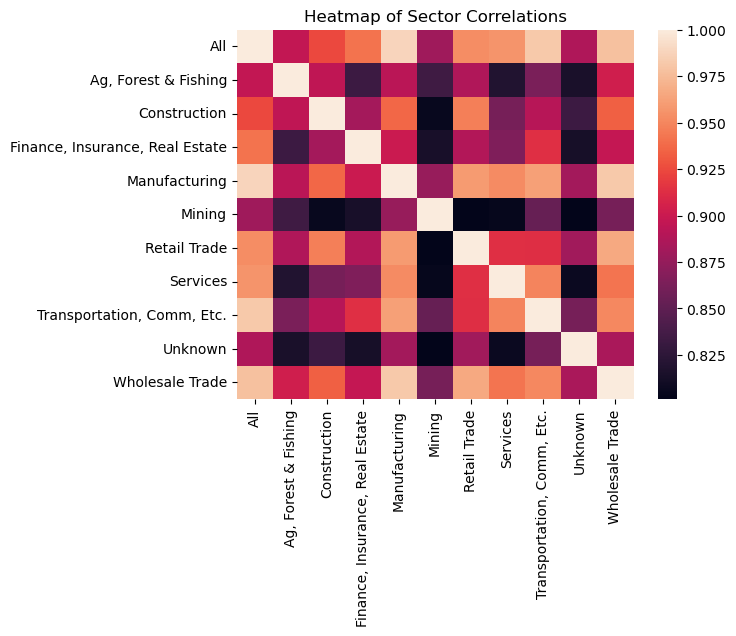

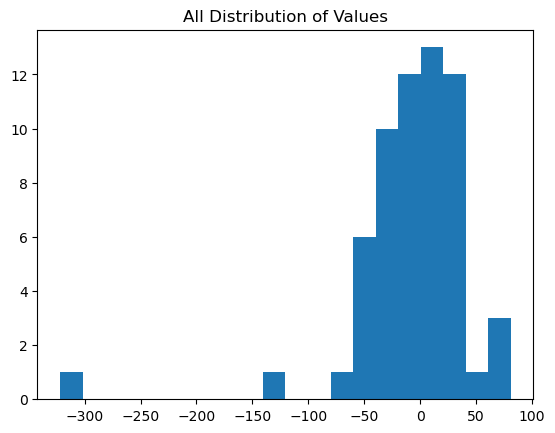

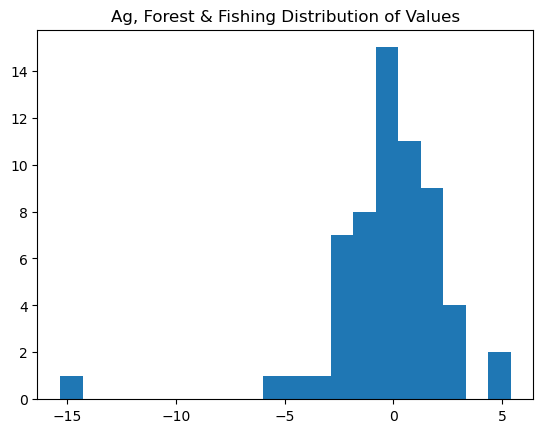

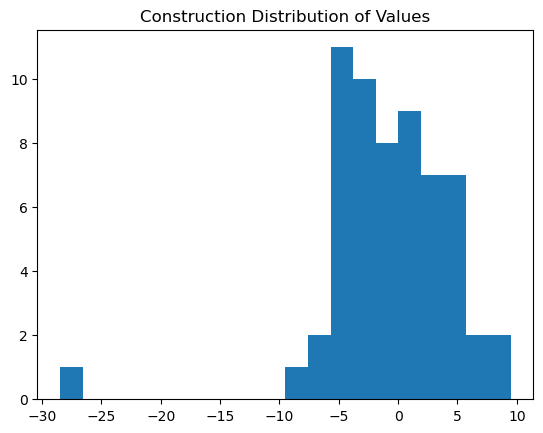

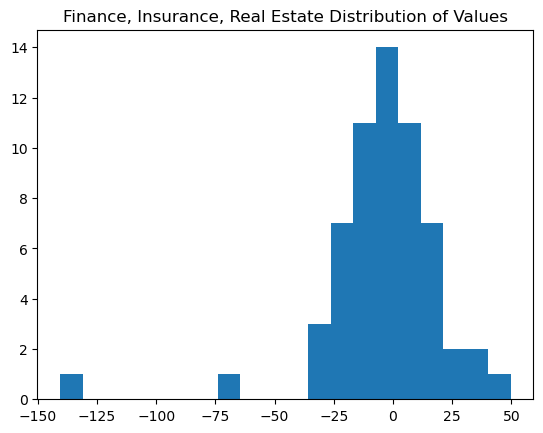

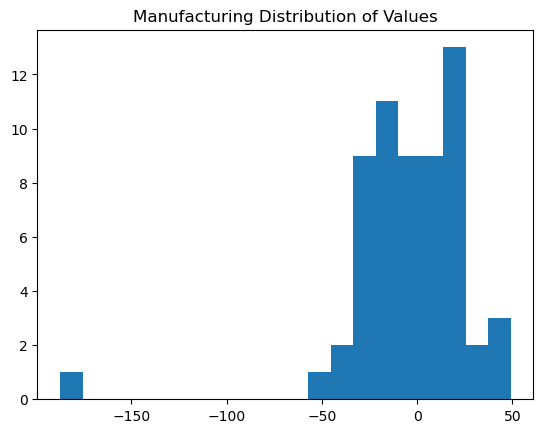

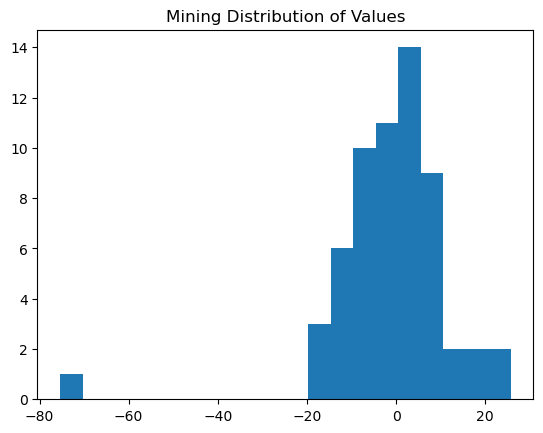

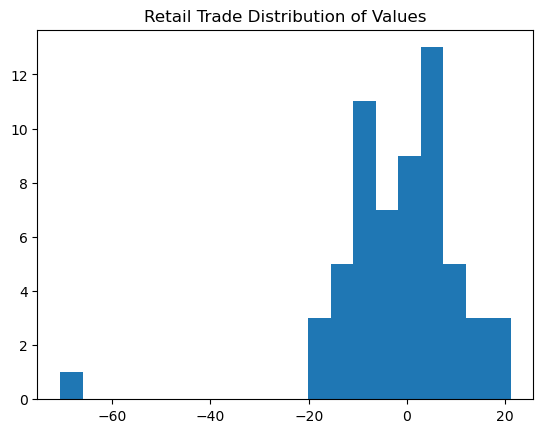

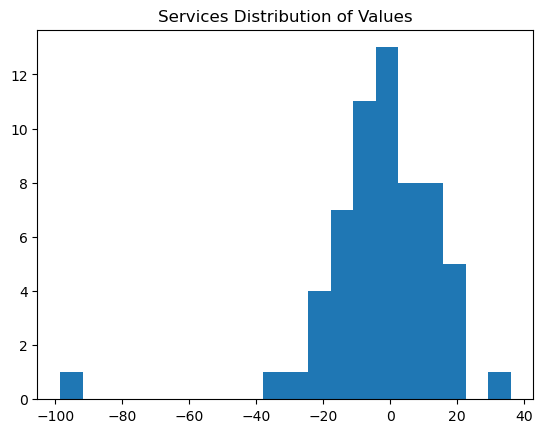

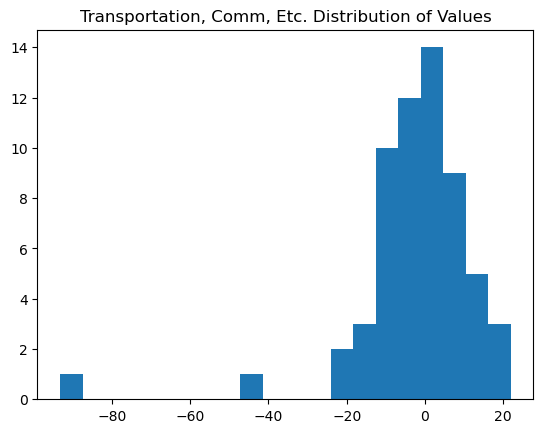

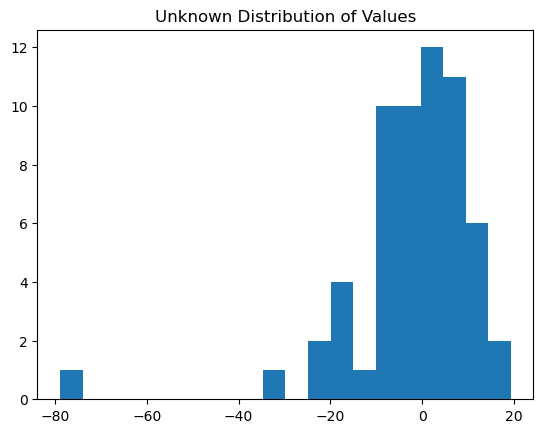

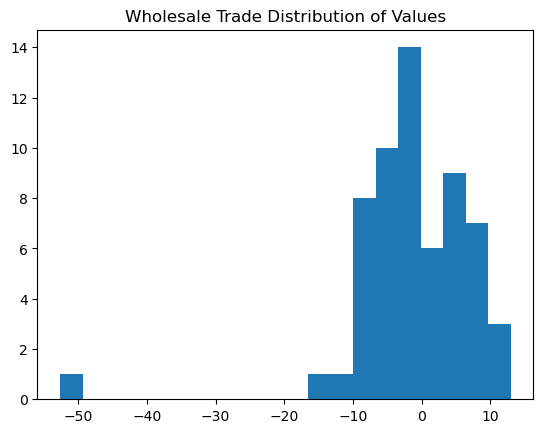

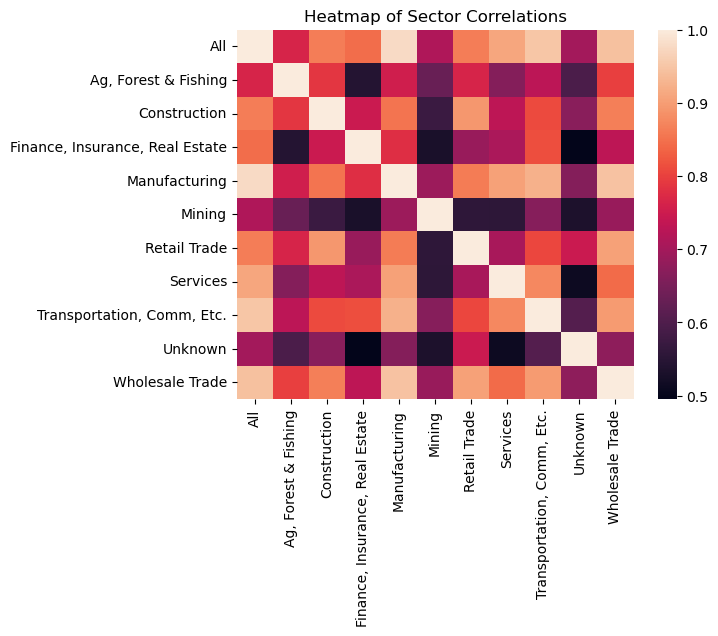

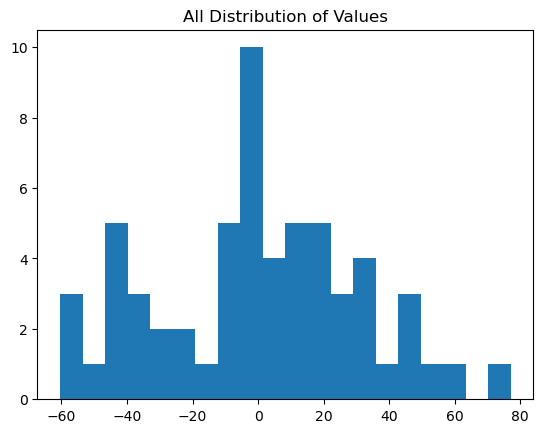

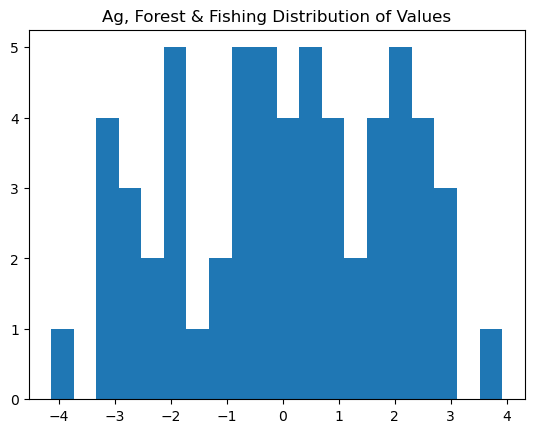

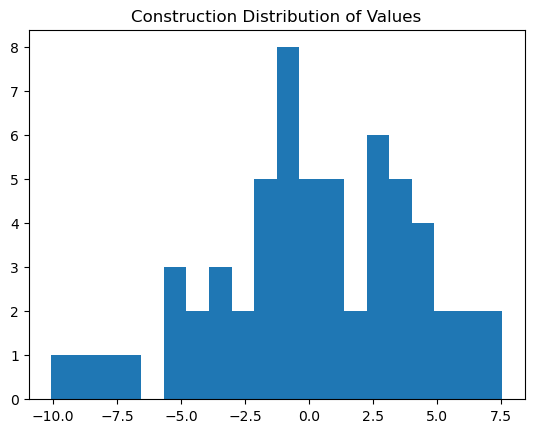

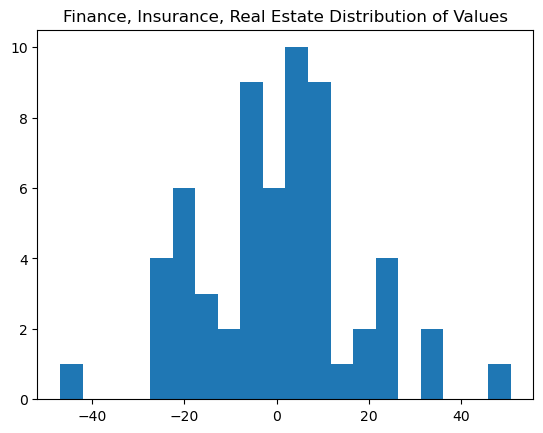

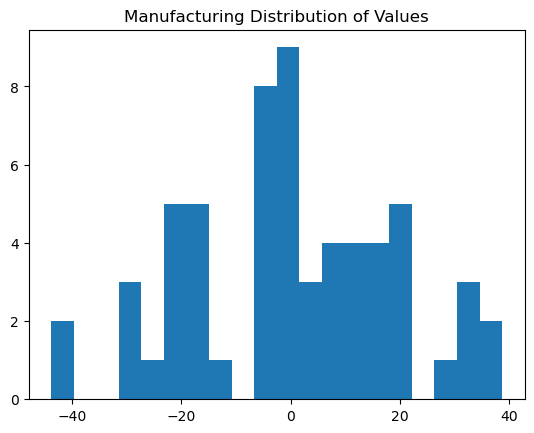

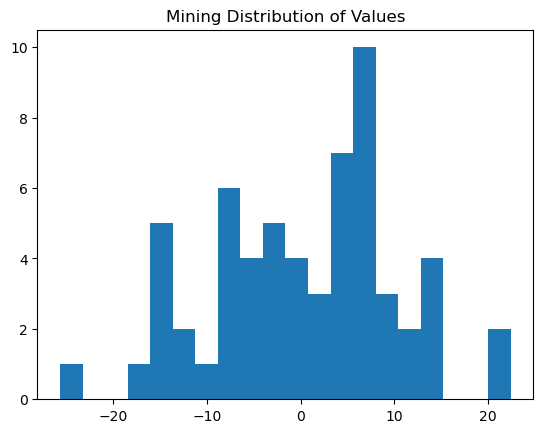

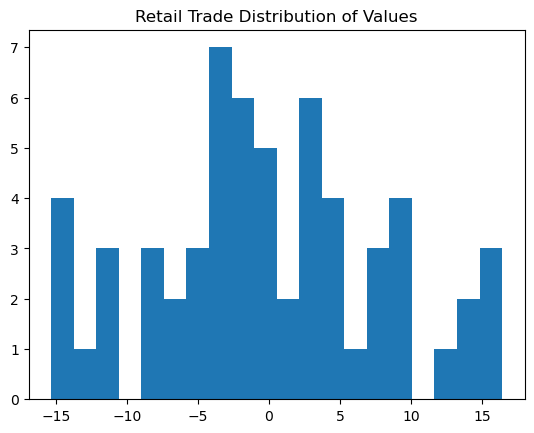

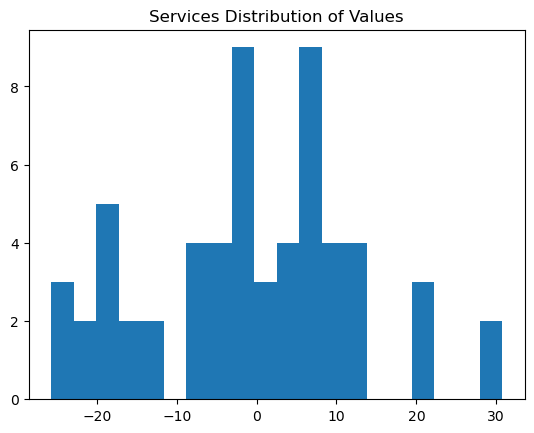

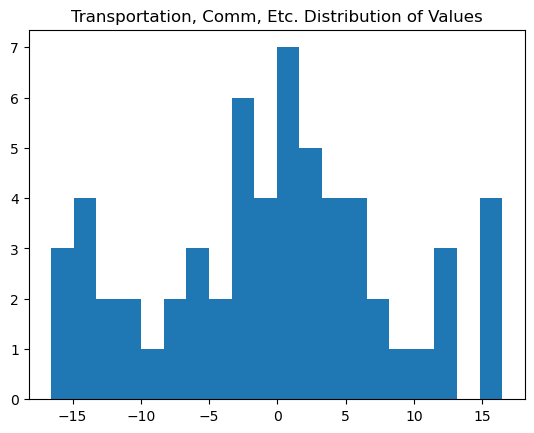

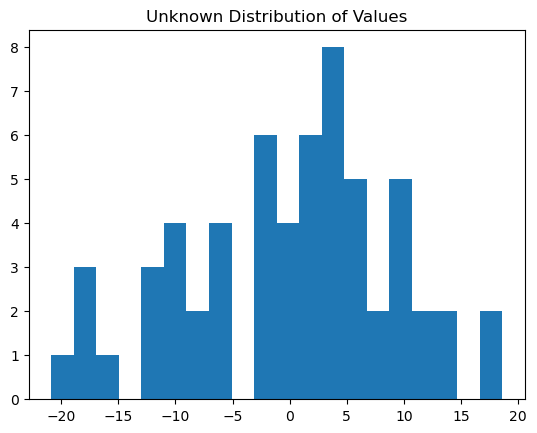

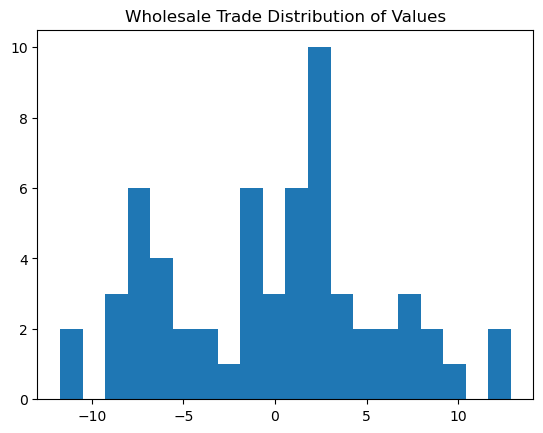

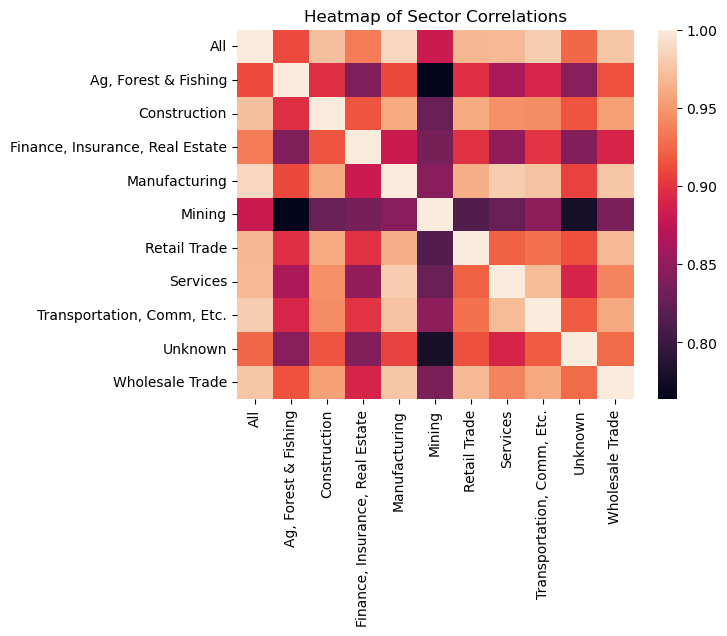

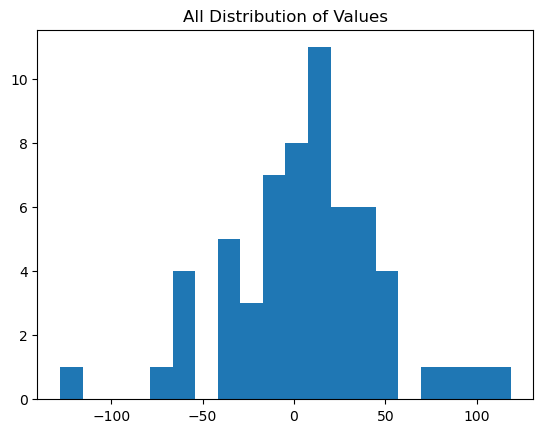

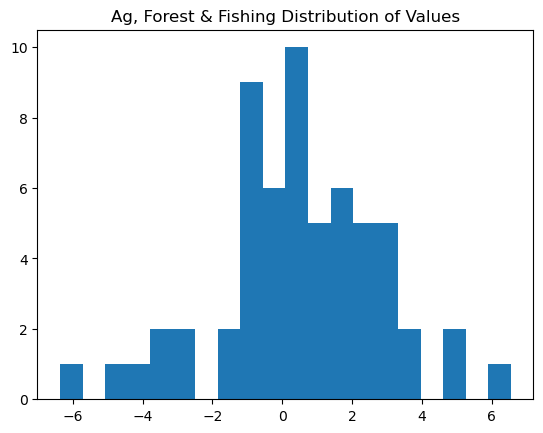

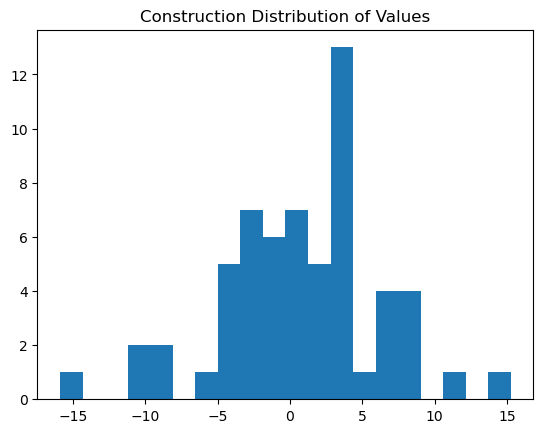

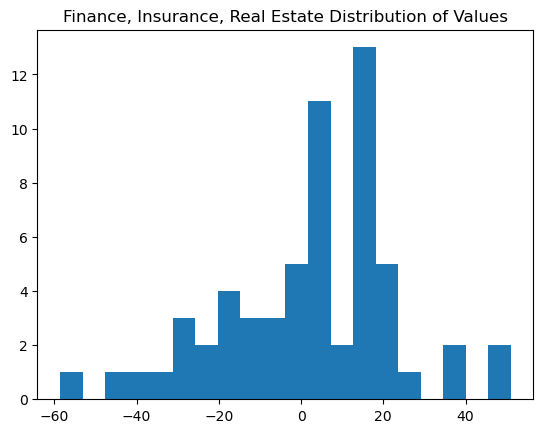

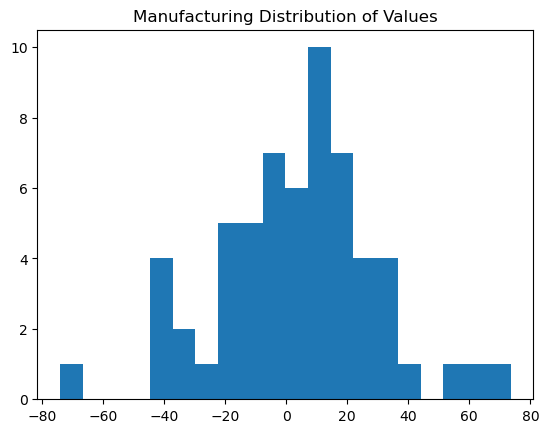

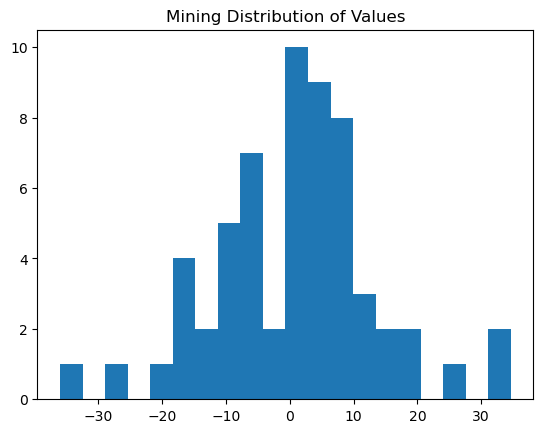

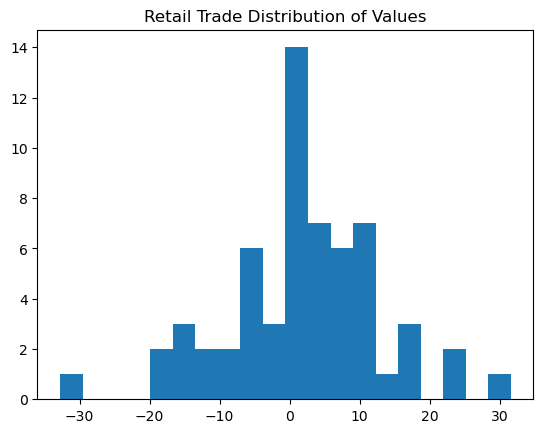

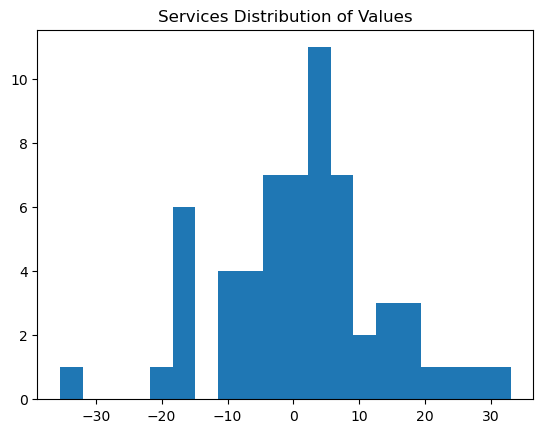

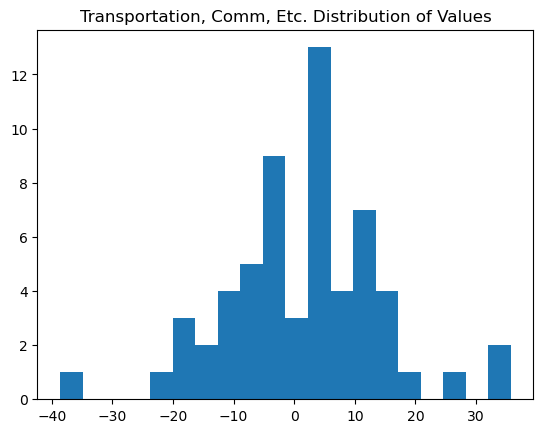

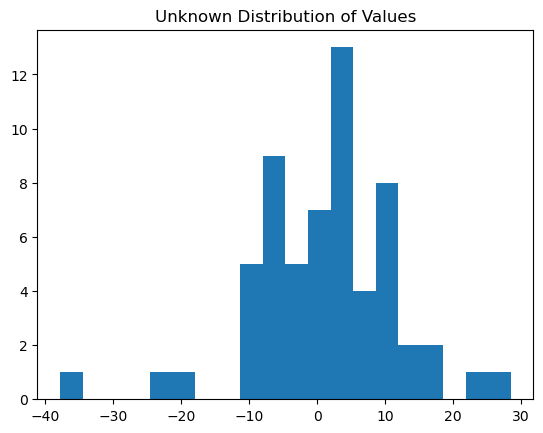

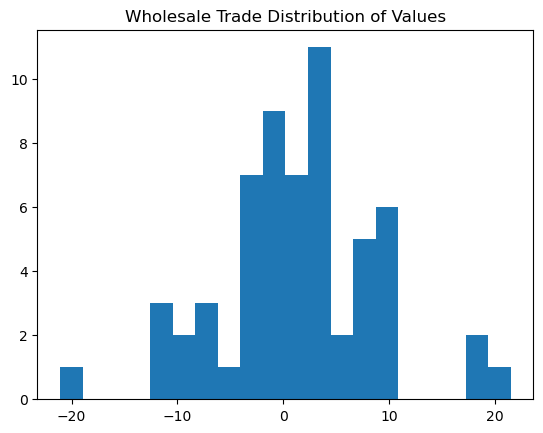

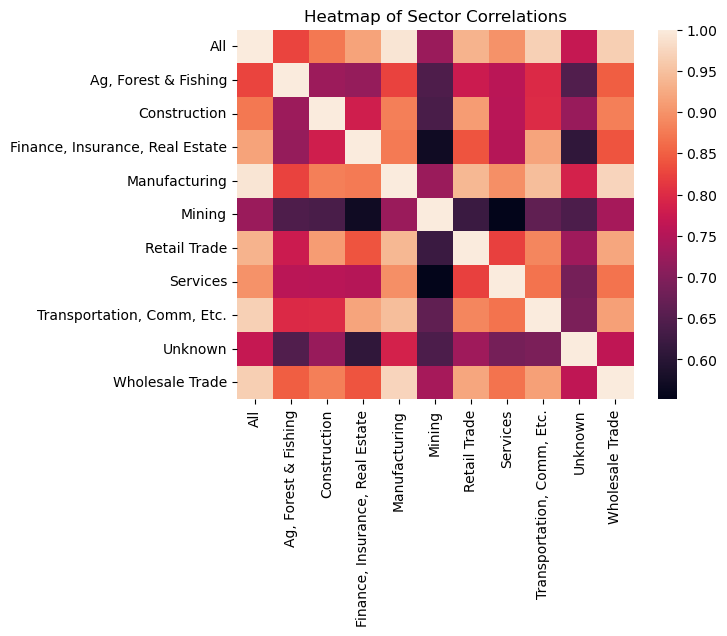

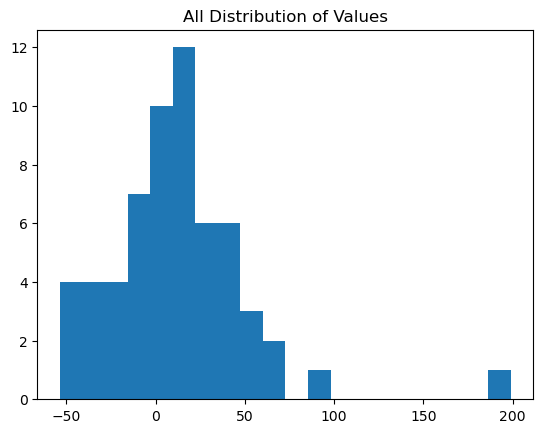

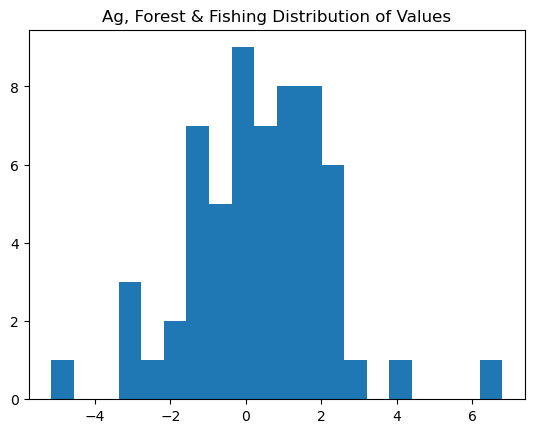

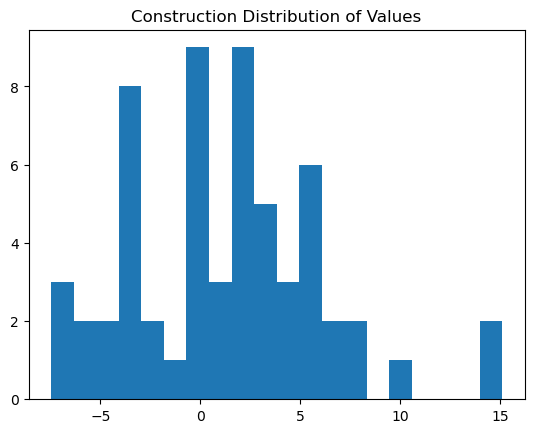

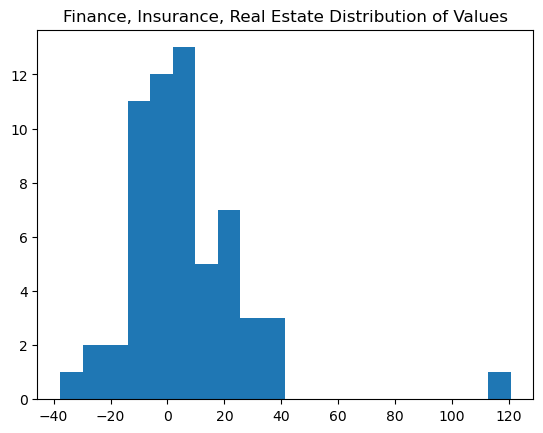

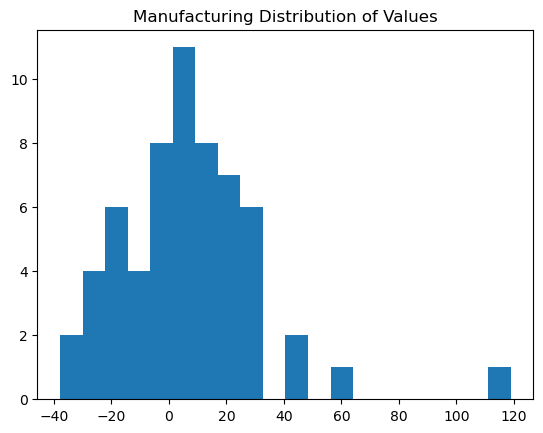

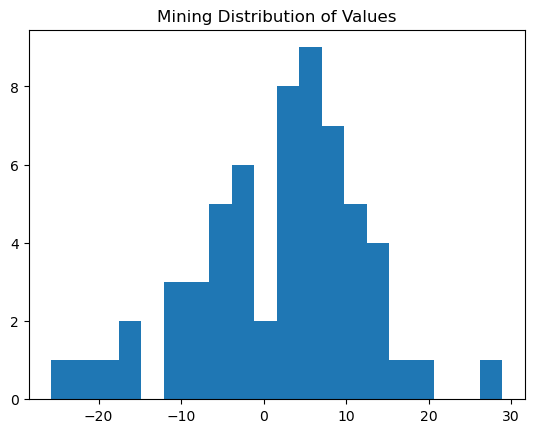

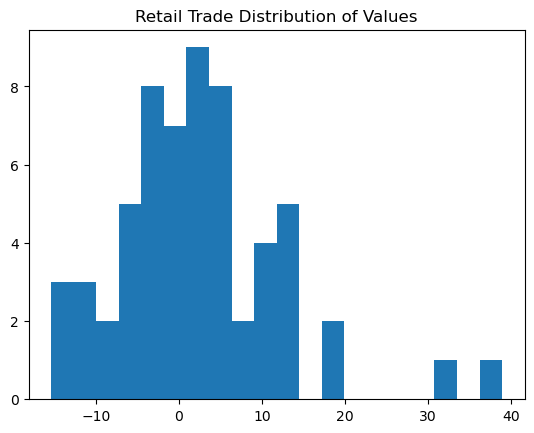

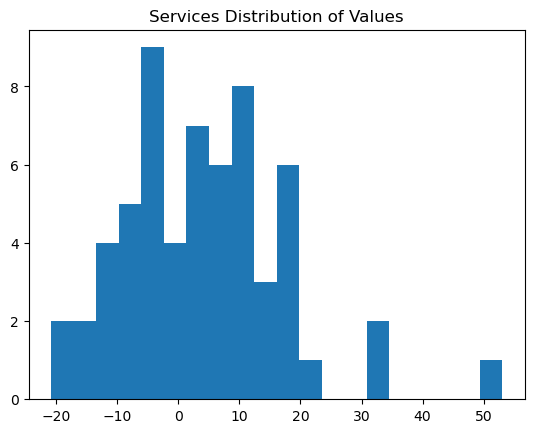

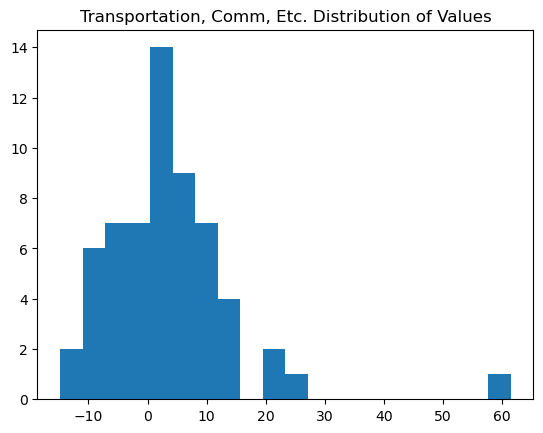

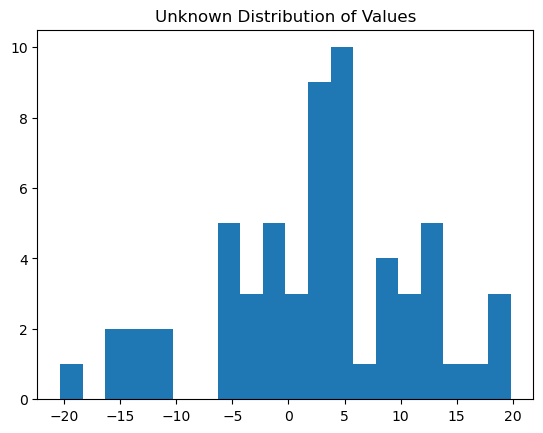

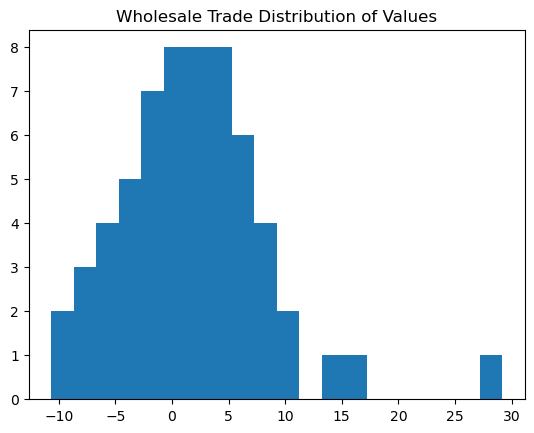

In [16]:
def corr_check(df):
    corr_df = df.astype(np.float).corr()
    sns.heatmap(corr_df)
    plt.title("Heatmap of Sector Correlations")
    plt.show()
    
def beta_hist(df):
    for col in df.columns:
        plt.title(col + " Distribution of Values")
        plt.hist(df[col], bins = 20)
        plt.show()

def quick_df_EDA(df):
    corr_check(df)
    beta_hist(df)

for df in df_dict.keys():
    quick_df_EDA(df_dict[df])
